In [1]:
import threadpoolctl
import time
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np

import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

from CBModellingFuncs import *

import cobra
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"
cobra_config.tolerance = 1e-6


#### Important - define number of processes
processes = 50
####

threadpoolctl.threadpool_limits(limits=processes)
os.makedirs("../results/dataframes/sampling", exist_ok=True)

In [2]:
model, m_warnings = cobra.io.validate_sbml_model("../results/iMT1026-NZ.xml")

rgdict = {}
for g in model.groups:
    for r in g.members:
        
        rgdict[r.id] = g.id.title()

SBML errors in validation, check error log for details.
COBRA warnings in validation, check error log for details.


In [3]:
DRinfo = pd.read_csv(f"../results/dataframes/cultivation_data/DerivedRetentInfo.csv", index_col=0, header=[0,1])
IRinfo = pd.read_csv(f"../results/dataframes/cultivation_data/InterpolatedRetentInfo.csv", index_col=0, header=[0,1])
FRinfo = pd.read_csv(f"../results/dataframes/cultivation_data/FittedRetentInfo.csv", index_col=0, header=[0,1])

NGAMseries = pd.read_csv('../results/dataframes/NGAMseries.csv',index_col=0,squeeze=True)

model_viab_cols = ["Growth Rate model 1/h", "qS model mmol/gh","qP model g/gh", "qCO2 viable model mmol/gh", "qO2 viable model mmol/gh", "qStorGlyc mmol/gh"]
viab_cols = ["Average Growth Rate 1/h", "qS viable mmol/gh","qP g/gh", "qCO2 viable mmol/gh", "qO2 viable mmol/gh", "qStorGlyc mmol/gh"] 

sp_gr = {'C0.1': '0.1',
         '0.0': '0.025',
         '0.9': '0.013',
         '1.9': '0.0073',
         '5.9': '0.0022',
         '7.9': '0.0017',
         '9.9': '0.0014',
         '13.9': '0.001',
         '16.9': '0.00083',
         '19.9': '0.00071',
         '23.9': '0.00059',
         '27.9': '0.00052'}

## Sampling

Generate chains for each different biomass equation at each different point during the retentostat cultivation

In [4]:
co2=True
optthin = 1000
o2 = True
n_chains = 4

- Uncomment the below cell to execute and generate all sampled chains - set processes, otherwise uses 50

In [5]:
# %%time

# sampling_results = []
# all_fva = []

# equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
# datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]


# for i, equation in enumerate(equation_names):
#     data = datasets[i].loc[:, model_viab_cols].copy()

#     for name, values in data.iterrows():
        
#         loop_start = time.time()
#         print(name)
#         mu = values[0]
#         sd = values[1]

#         with model as temp_model:
#             set_biomass_objective(temp_model, equation, name)
#             print(f"{equation} - {name}")
            
#             temp_model.reactions.ATPM.bounds = (NGAMseries[f"{equation}"],1000)
            
 
#             solution = constrain_predict(temp_model, values, co2=co2, o2=o2)
#             pred_mu = solution.objective_value

#             if equation in ["Consensus", "ScaledConsensus"]:
#                 temp_model.reactions.get_by_id(equation).bounds =  (pred_mu*0.95, pred_mu)
                
#             else:
#                 temp_model.reactions.get_by_id(f"{equation}Biomass{name}").bounds = (pred_mu*0.95, pred_mu) 
               
#             flux_span = constrain_predict(temp_model, values, co2=co2, fluxva=True, processes=processes,fopt=0)
#             remove_blocked(temp_model, flux_span, solution)


#             fva_frame = flux_span.stack(0).to_frame().T
#             fva_frame["Equation"] = equation
#             fva_frame["Time"] = name
#             fva_frame.set_index(["Equation", "Time"], inplace=True)
#             all_fva.append(fva_frame)
            
#             chains = constrain_predict(temp_model, values, sampling=True, chains=n_chains, thinning=optthin, 
#                                        loopless=True, processes=processes, co2=co2, o2=o2, n_samples=1250)#5000)

#                  # ensure all have same number of samples, may have
#             chains = [df.iloc[:min([df.shape[0] for df in chains]), :] for df in chains]
#             print(f"{equation} chains with all have length of {chains[0].shape[0]}") 

#             for j, chain in enumerate(chains):
            
#                 chain["Chain"] = j+1
#             chains = pd.concat(chains, ignore_index=True)
#             chains.to_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz", 
#                                 compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

#             now = time.time()
#             print(f"It has been {(now - loop_start)/60} minutes since the {name} sampling point loop started")
# ####

# all_fva = pd.concat(all_fva)
# gr_values = all_fva.index.get_level_values(1).to_series().apply(lambda x: sp_gr[x]).values
# gr_values = pd.Series(gr_values.astype(float), name="Growth Rate")
# all_fva.set_index(gr_values, append=True, inplace=True)
# all_fva.to_csv(f"../results/dataframes/fluxes/FVA_ranges.csv")

C0.1
Consensus - C0.1
2387 reactions before making consistent, 1425 after
Consensus chains with all have length of 1250
It has been 4.113780824343364 minutes since the C0.1 sampling point loop started
0.0
Consensus - 0.0
2387 reactions before making consistent, 1455 after
Consensus chains with all have length of 1250
It has been 4.225286114215851 minutes since the 0.0 sampling point loop started
0.9
Consensus - 0.9
2387 reactions before making consistent, 1450 after
Consensus chains with all have length of 1250
It has been 4.270313902695974 minutes since the 0.9 sampling point loop started
1.9
Consensus - 1.9
2387 reactions before making consistent, 1451 after
Consensus chains with all have length of 1250
It has been 4.229973149299622 minutes since the 1.9 sampling point loop started
5.9
Consensus - 5.9
2387 reactions before making consistent, 1449 after
Consensus chains with all have length of 1250
It has been 4.229129401842753 minutes since the 5.9 sampling point loop started
7.9
Con

# Analysis of sampled chains

## Convergence check

In [6]:
%%time
all_stats = pd.DataFrame()


equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]

n_chains = 4

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()
    all_df = []

    for name, values in data.iterrows():
        
        
        chains = pd.read_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz") 
        chains = [chains.set_index("Chain").loc[j+1].reset_index(drop=True) for j in range(n_chains)]
        

        grouped, rxns = extractchains(chains)
        
        for_pool = list(zip(grouped,rxns))
        pool = Pool(processes=processes)
        all_series = pool.starmap(calculateDiagnostics, for_pool)
        pool.close()
        df = pd.concat(all_series,axis=1).T
        df["Equation"] = name
        
        all_df.append(df)
    all_df = pd.concat(all_df, ignore_index=True)
    all_df["Method"] = equation
    
    all_stats = pd.concat([all_stats, all_df], ignore_index=True)
      
n_grouped_chains = all_stats.groupby(["Method", "Equation"]).count()["Rxn"]

all_stats.set_index(["Method", "Equation", "Rxn"], inplace=True)
all_stats["Rhat Fails"] = all_stats["Rhat"] > 1.01
all_stats["ESS-Bulk Fails"] = all_stats["ESS-Bulk"] < 400


summary_stats = all_stats.copy() #all_stats[["Geweke Fails","ESS Split Fails", "Rhat Fails", "ESS-Bulk Fails"]]
summary_stats.index = summary_stats.index.reorder_levels(["Rxn", "Method", "Equation"])#-1,0,1])

chain_summary = (summary_stats > 0).groupby(["Method", "Equation"]).sum()
# chain_summary = chain_summary[["Geweke Fails","ESS Split Fails", "Rhat Fails", "ESS-Bulk Fails"]]
chain_summary = chain_summary[["Geweke Fails","Rhat Fails", "ESS-Bulk Fails"]]
temp_df = (chain_summary.divide(n_grouped_chains, axis=0) * 100)

# temp_df.columns=["% Geweke Fails","% seperated-ESS Fails","% Rhat Fails","% bulk-ESS Fails"]
temp_df.columns=["% Geweke Fails","% Rhat Fails","% bulk-ESS Fails"]

chain_summary = pd.concat([chain_summary,temp_df],axis=1)
chain_summary.to_csv(f"../results/dataframes/sampling/Sampling_DiagnosticsChains.csv")

n_method_samples = len(summary_stats.index.droplevel("Rxn").unique())

rxn_summary = summary_stats.copy()

# rxn_summary = rxn_summary[rxn_summary.loc[:,["ESS Split Fails","Rhat Fails", "ESS-Bulk Fails"]].sum(axis=1) > 0]
rxn_summary = rxn_summary[rxn_summary.loc[:,["Rhat Fails", "ESS-Bulk Fails"]].sum(axis=1) > 0]
rxn_summary.to_csv(f"../results/dataframes/sampling/Sampling_DiagnosticsReactions.csv")

CPU times: user 43.1 s, sys: 52.1 s, total: 1min 35s
Wall time: 2min 26s


In [7]:
rxn_summary

Geweke Fails      Rhat  \
Rxn               Method          Equation                          
CO2t              Consensus       C0.1                4  1.054097   
Ex_co2            Consensus       C0.1                4  1.054097   
PTE161x           Consensus       0.0                 4  1.008306   
PTE181x           Consensus       0.0                 2  1.015985   
DPRm              Consensus       0.0                 3  1.011717   
...                                                 ...       ...   
GLCt1             ScaledConsensus 23.9                2  1.313169   
HEX1              ScaledConsensus 23.9                1  1.313314   
Ex_glc_D          ScaledConsensus 23.9                2  1.313169   
SK_glycogen_c     ScaledConsensus 23.9                4  1.344578   
FAO182p_even_even ScaledConsensus 27.9                0  1.013483   

                                               ESS-Bulk     ESS-Tail  \
Rxn               Method          Equation                             
CO2t              Consensus       C0.1       883.864791  1047.111109   
Ex_co2            Consensus       C0.1       883.864791  1039.011912   
PTE161x           Consensus       0.0        366.462897   739.924567   
PTE181x           Consensus       0.0        326.201666   749.531739   
DPRm              Consensus       0.0        380.510598   363.227627   
...                                                 ...          ...   
GLCt1             ScaledConsensus 23.9        10.541138    157.21047   
HEX1              ScaledConsensus 23.9        10.577554    157.21047   
Ex_glc_D          ScaledConsensus 23.9        10.541138   174.972538   
SK_glycogen_c     ScaledConsensus 23.9         10.29758   143.555418   
FAO182p_even_even ScaledConsensus 27.9      1882.875834   2255.16268   

                                            Rhat Fails  ESS-Bulk Fails  
Rxn               Method          Equation                              
CO2t              Consensus       C0.1            True           False  
Ex_co2            Consensus       C0.1            True           False  
PTE161x           Consensus       0.0            False            True  
PTE181x           Consensus       0.0             True            True  
DPRm              Consensus       0.0             True            True  
...                                                ...             ...  
GLCt1             ScaledConsensus 23.9            True            True  
HEX1              ScaledConsensus 23.9            True            True  
Ex_glc_D          ScaledConsensus 23.9            True            True  
SK_glycogen_c     ScaledConsensus 23.9            True            True  
FAO182p_even_even ScaledConsensus 27.9            True           False  

[851 rows x 6 columns]

In [8]:
roi = ["G6PDH2","PGI","PYK","MDHm","CSm","AKGMALtm","NADH2_u6cm","NADH2_u6mh","CYOR_u6m","CYOOm","ATPS3m","ATPM"]
if (rxn_summary.index.get_level_values("Rxn").isin(roi)).any():
    output = rxn_summary.loc[roi]
    output.to_csv(f"../results/dataframes/sampling/Sampling_FailedReactionsOfInterest.csv")
else:
    output = "No reactions of interest failed to converge"
    
output

'No reactions of interest failed to converge'

In [9]:
chain_summary

Geweke Fails  Rhat Fails  ESS-Bulk Fails  \
Method          Equation                                             
Consensus       0.0                651          10               6   
                0.9                274           0               0   
                1.9                333           7               0   
                13.9               264         310               9   
                16.9               375           4               1   
                19.9               353           0               0   
                23.9               326           4               4   
                27.9               333           3               0   
                5.9                370           3               3   
                7.9                377           5               3   
                9.9                489          15               6   
                C0.1               313           2               0   
Derived         0.0                560           1               0   
                0.9                303           0               0   
                1.9                206           1               0   
                13.9               237           5               5   
                16.9               692           9               2   
                19.9               314           5               2   
                23.9               456           2               2   
                27.9               190           1               0   
                5.9                203           3               3   
                7.9                270           3               3   
                9.9                322          11               6   
                C0.1               404           4               0   
Fitted          0.0                205           3               0   
                0.9                165           0               0   
                1.9                345           0               0   
                13.9               285         248              12   
                16.9               258           4               0   
                19.9               266           3               0   
                23.9               411          24               3   
                27.9               252           3               0   
                5.9                326          10               8   
                7.9                238           6               3   
                9.9                469          20               5   
                C0.1               403          15               1   
Interpolated    0.0                191           0               0   
                0.9                203           4               0   
                1.9                466           6               2   
                13.9               364           3               3   
                16.9               273           3               0   
                19.9               250           3               0   
                23.9               340          10               9   
                27.9               186           7               0   
                5.9                305           3               3   
                7.9                355           3               3   
                9.9                154          13               1   
                C0.1               436          11               0   
ScaledConsensus 0.0                364           0               0   
                0.9                352           2               0   
                1.9                303           0               0   
                13.9               380           1               1   
                16.9               452          12               7   
                19.9               287           3               1   
                23.9               393           4               4   
                27.9               2

## Analysis of flux distributions

##### Import all flux prediction results
##### Calculate flux yields
##### Calculate quantiles of the sampling results

In [10]:
all_pfba = pd.read_csv("../results/dataframes/fluxes/AllpFBA_results.csv", header=[0,1], index_col=0)
all_pfba = all_pfba.T 

gr_values = all_pfba.index.get_level_values(1).to_series().apply(lambda x:sp_gr[x])
gr_values.name = "Growth Rate"

all_pfba.set_index(gr_values,append=True, inplace=True)

norm_pfba = all_pfba.div(all_pfba["Ex_glc_D"].abs(),axis=0)
norm_pfba.sort_index(inplace=True)

all_fva = pd.read_csv(f"../results/dataframes/fluxes/FVA_ranges.csv",header=[0,1],index_col=[0,1,2])
norm_fva = all_fva.div(all_fva["Ex_glc_D"].abs().mean(axis=1),axis=0)

In [11]:
%%time
import re
all_chains = []


equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()
    all_df = []

    for name, values in data.iterrows():
        
        chains = pd.read_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz") 
        merged = chains.drop(columns="Chain")
        chains = [chains.set_index("Chain").loc[j+1].reset_index(drop=True) for j in range(n_chains)]
        
        mask = pd.concat([(chain == 0).all(axis=0) for chain in chains],axis=1).any(axis=1)
        
        merged = merged.loc[:,~mask]
        # remove any samples with very high fluxes
        merged = merged[(merged != 1000).all(axis=1)]
        
        merged["Equation"] = equation
        merged["Time"] = name
        
        all_chains.append(merged)

all_chains_df = pd.concat(all_chains).fillna(0)
all_chains_df.reset_index(inplace=True)
all_chains_df.rename(columns={"index":"Chain"},inplace=True)
all_chains_df["Growth Rate"] = all_chains_df.Time.apply(lambda x: sp_gr[x])
all_chains_df.set_index(["Equation", "Time", "Chain", "Growth Rate"],inplace=True)
all_chains_df = all_chains_df.sort_index(level=-1, ascending=False)
all_chains_df.to_pickle(f"../results/dataframes/fluxes/AllChains.pkl.gz", compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

quants = all_chains_df.groupby(["Equation", "Time", "Growth Rate"]).quantile([0.025, 0.975]) # [0.0125, 0.9875])
quants = quants.unstack().sort_index(level=["Equation","Growth Rate"],ascending=False)

# Normalise all samples to their glucose uptake rate
norm_chains_df = all_chains_df.div(all_chains_df["Ex_glc_D"].abs(), axis=0)
norm_chains_df.to_pickle(f"../results/dataframes/fluxes/NormChains.pkl.gz", compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

# Calculate the quantiles
norm_quants = norm_chains_df.groupby(["Equation", "Time", "Growth Rate"]).quantile([0.025, 0.975]) # [0.0125, 0.9875])
norm_quants = norm_quants.unstack().sort_index(level=["Equation","Growth Rate"],ascending=False)
norm_quants.to_csv(f"../results/dataframes/fluxes/95%CIFluxRatios.csv") 
norm_quants.loc[:, ["G6PDH2", "PGI","PGMT", "TRE6PS", "PFK", 
               "PYK", "PC", "PDHa1", "CSm", "ASPTA",
               "ASPTAm",  "AKGMALtm", "ASPGLU2m",
               "MDH", "MDHm","ME1m" , "Ex_nh4"]].to_csv(f"../results/dataframes/fluxes/95%CIFluxRatiosInteresting.csv")

CPU times: user 5min 48s, sys: 9 s, total: 5min 57s
Wall time: 5min 56s


##### Calculate the production fluxes of cofactors

In [12]:
%%time 

interested_cofactors = ['atp_c', 'nadh_c', 'nad_c', 'nadph_c', 'nadp_c', 'atp_m', 'nadh_m','nad_m', 'nadph_m', 'nadp_m',
                      'atp_x', 'nadh_x','nad_x', 'nadph_x','nadp_x']

sm = cobra.util.array.create_stoichiometric_matrix(model, array_type='DataFrame', dtype=None)

# Calculate total cofactor production, as well as what proportion of the supply comes from which pathway

cofactors_total_supply, cof_rxn_supply = calculate_cofactors(all_chains_df,interested_cofactors,sm, source=True)
cofactors_total_supply = cofactors_total_supply.loc[:,(cofactors_total_supply > 0).any()]
cofactors_ranges = cofactors_total_supply.groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]) # 0.0125, 0.9875])
cofactors_ranges = cofactors_ranges.T.stack([0,2])
cofactors_ranges = cofactors_ranges.sort_index(axis=1,ascending=False)
cofactors_ranges.to_csv(f"../results/dataframes/fluxes/TotalCofactorRanges.csv")

cof_rxn_supply2 = cof_rxn_supply.loc[(~cof_rxn_supply.isna().all(axis=1)),
                                        (~cof_rxn_supply.isna().all())]
cof_rxn_supply2 = cof_rxn_supply2.loc[:,(cof_rxn_supply2 > 1e-6).any()]
subsystem_supply = cof_rxn_supply2.rename(columns=rgdict)
subsystem_supply = subsystem_supply.groupby(subsystem_supply.columns,axis=1).sum()
subsystem_supply = subsystem_supply.T.stack(0)
subsystem_supply = subsystem_supply[subsystem_supply.sum(axis=1) > 0]

# # calculate what proportion of each cofactors is from pathways
subsystem_supply = subsystem_supply.unstack(1)
subsystem_supply = subsystem_supply.div(subsystem_supply.T.sum(axis=1))
subsystem_supply = subsystem_supply.T.droplevel("Time")
subsystem_supply = subsystem_supply.unstack("Growth Rate").stack(0)
subsystem_supply = subsystem_supply.reorder_levels([1,0,-1]).sort_index()
subsystem_supply = subsystem_supply.round(3)*100
subsystem_supply = subsystem_supply.loc[~(subsystem_supply == 0).all(axis=1).groupby(level=[0,1,2]).any(0),:]
subsystem_supply.to_csv("../results/dataframes/fluxes/MajorCofactorsProductionBySubsystems.csv")

cofactors_norm_total_supply = calculate_cofactors(norm_chains_df,interested_cofactors,sm)
cofactors_norm_total_supply = cofactors_norm_total_supply.loc[:,(cofactors_norm_total_supply > 0).any()]
cofactors_norm_ranges = cofactors_norm_total_supply.groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]) # 0.0125, 0.9875])
cofactors_norm_ranges = cofactors_norm_ranges.T.stack([0,2])
cofactors_norm_ranges = cofactors_norm_ranges.sort_index(axis=1,ascending=False)
cofactors_norm_ranges.to_csv(f"../results/dataframes/fluxes/NormalisedCofactorRanges.csv")


CPU times: user 1min 51s, sys: 33.2 s, total: 2min 24s
Wall time: 2min 24s


##### Calculate proportion of pFBA results within 95% confidence interval

In [13]:
equation_names =  ["Consensus","Derived", "Fitted", "Interpolated", "ScaledConsensus"]

col_mask = norm_quants.columns.get_level_values(0).unique()
col_mask = col_mask.drop(["growth"]) #, "GAME", "GAM"])

masked_npfba = norm_pfba.loc[equation_names,col_mask].copy()


poplo = np.zeros(masked_npfba.shape)

poplo=pd.DataFrame(0,
                   index=masked_npfba.index,
                   columns=masked_npfba.columns)

for i, row in masked_npfba.iterrows():
    nans = row[row.isna()]
    poplo.loc[i, nans.index] = 2
    temp_row = row[row.notna()]
    poplo.loc[i, temp_row.index] = (temp_row >= norm_quants.loc[i, temp_row.index].unstack()[0.025])&(temp_row <= norm_quants.loc[i, temp_row.index].unstack()[0.975])

    

print(f"{round(100* ((poplo == True).sum(axis=1)/ ((poplo == True).sum(axis=1)+(poplo == False).sum(axis=1))).mean(),2)}% pFBA results within 95% CI")

proportion = ((poplo == True).sum(axis=0)/(poplo != 2).sum(axis=0))*100
proportion = proportion.rename(rgdict)
proportion = proportion.reset_index().rename(columns={"index":"Subsystem",0:"Proportion"})

# Count how many members in each group
count_prop = proportion.groupby(by=["Subsystem"]).count()
# if only 3 members or less of subsystem, drop
proportion = proportion[proportion.Subsystem.isin(count_prop.index[(count_prop > 3).values.flatten()])]
median_proportions = proportion.groupby("Subsystem").median().sort_values("Proportion",ascending=False)
median_proportions.to_csv(f"../results/dataframes/sampling/Proportions_FBA_95CI.csv")
median_proportions

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/ops/common.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


70.7% pFBA results within 95% CI


Proportion
Subsystem                                                     
Glycerolipid Metabolism                             100.000000
Fatty Acid Degradation                              100.000000
Inositol Phosphate Metabolism                       100.000000
Pyruvate Metabolism                                 100.000000
N-Glycan Metabolism                                 100.000000
Propanoate Metabolism                               100.000000
Nucleotide Metabolism                               100.000000
Fructose And Mannose Metabolism                     100.000000
Transport, Golgi Apparatus                          100.000000
Transport, Nuclear                                  100.000000
Transport, Peroxisomal                              100.000000
Transport, Vacuolar                                 100.000000
Phospholipid Metabolism                             100.000000
Arginine And Proline Metabolism                     100.000000
Methanol Metabolism                                 100.000000
Methionine Metabolism                                98.333333
Cysteine Metabolism                                  98.333333
Pyridoxine Metabolism                                98.333333
Glutamate Metabolism                                 97.500000
Tyrosine, Tryptophan, And Phenylalanine Metabolism   97.500000
Other Amino Acid Metabolism                          96.666667
Glycine And Serine Metabolism                        94.166667
Pantothenate And Coa Biosynthesis                    93.333333
Oxidative Phosphorylation                            90.833333
Other                                                90.000000
Carbohydrate Metabolism                              90.000000
Thiamine Metabolism                                  88.333333
Vitamin And Cofactor Biosynthesis                    86.666667
Folate Metabolism                                    84.166667
Pentose Phosphate Pathway                            83.333333
Sphingolipid Metabolism                              81.666667
Glyoxylate And Dicarboxylate Metabolism              73.333333
Glycolysis/Gluconeogenesis                           73.333333
Nad Biosynthesis                                     71.666667
Biomass Composition                                  61.666667
Fatty Acid Biosynthesis                              61.666667
Riboflavin Metabolism                                57.500000
Transport, Mitochondrial                             56.666667
Valine, Leucine, And Isoleucine Metabolism           41.666667
Citric Acid Cycle                                    31.666667
Quinone Biosynthesis                                 18.333333
Transport, Extracellular                             16.666667
Porphyrin And Chlorophyll Metabolism                 11.666667
Alanine And Aspartate Metabolism                     10.000000
Transport, Er                                         8.333333
Histidine Metabolism                                  8.333333
Exchange Reaction                                     5.000000
Threonine And Lysine Metabolism                       3.333333
Amino Sugar And Nucleotide Sugar Metabolism           1.666667
Sterol Metabolism                                     1.666667

Median of sampled fluxes of PGI and G6PDH2 for each biomass equation at each growth rates

In [14]:
median_chains = norm_chains_df.reset_index().groupby(["Equation", "Growth Rate"]).median()
median_chains.to_csv(f"../results/dataframes/fluxes/MedianChains.csv")
median_chains.loc[:,["G6PDH2","PGI"]].T.stack(0)

Growth Rate              0.00052   0.00059   0.00071   0.00083     0.001  \
       Equation                                                            
G6PDH2 Consensus        0.083777  0.095185  0.110120  0.127455  0.139855   
       Derived          0.092046  0.099301  0.106231  0.113866  0.122329   
       Fitted           0.071880  0.070926  0.076043  0.085261  0.096363   
       Interpolated     0.070490  0.069486  0.076198  0.083540  0.094309   
       ScaledConsensus  0.102977  0.113759  0.131000  0.145862  0.164692   
PGI    Consensus        0.883751  0.879633  0.865948  0.840673  0.814274   
       Derived          0.832237  0.835915  0.827878  0.810910  0.787523   
       Fitted           0.865216  0.863109  0.849058  0.829582  0.805751   
       Interpolated     0.866884  0.864560  0.849122  0.831134  0.807168   
       ScaledConsensus  0.856556  0.853002  0.837041  0.814165  0.781716   

Growth Rate               0.0014    0.0017    0.0022    0.0073     0.013  \
       Equation                                                            
G6PDH2 Consensus        0.170458  0.196747  0.224100  0.341223  0.378415   
       Derived          0.132552  0.140799  0.155720  0.204280  0.216236   
       Fitted           0.114417  0.126553  0.145664  0.206854  0.228692   
       Interpolated     0.113773  0.130289  0.142989  0.210964  0.231340   
       ScaledConsensus  0.187662  0.211720  0.241094  0.365351  0.404129   
PGI    Consensus        0.761468  0.725926  0.685276  0.513995  0.463631   
       Derived          0.750126  0.725520  0.686928  0.547830  0.510433   
       Fitted           0.765333  0.737953  0.697632  0.554703  0.513342   
       Interpolated     0.765405  0.735521  0.703235  0.551557  0.515460   
       ScaledConsensus  0.736407  0.703124  0.660424  0.486745  0.434635   

Growth Rate                0.025       0.1  
       Equation                             
G6PDH2 Consensus        0.410279  0.438912  
       Derived          0.256410  0.311941  
       Fitted           0.254343  0.310589  
       Interpolated     0.249398  0.318517  
       ScaledConsensus  0.434264  0.451620  
PGI    Consensus        0.417764  0.377637  
       Derived          0.468600  0.437784  
       Fitted           0.470271  0.439129  
       Interpolated     0.475543  0.431188  
       ScaledConsensus  0.392011  0.360026

### Plotting 

##### Plot ridge plots of interested reactions

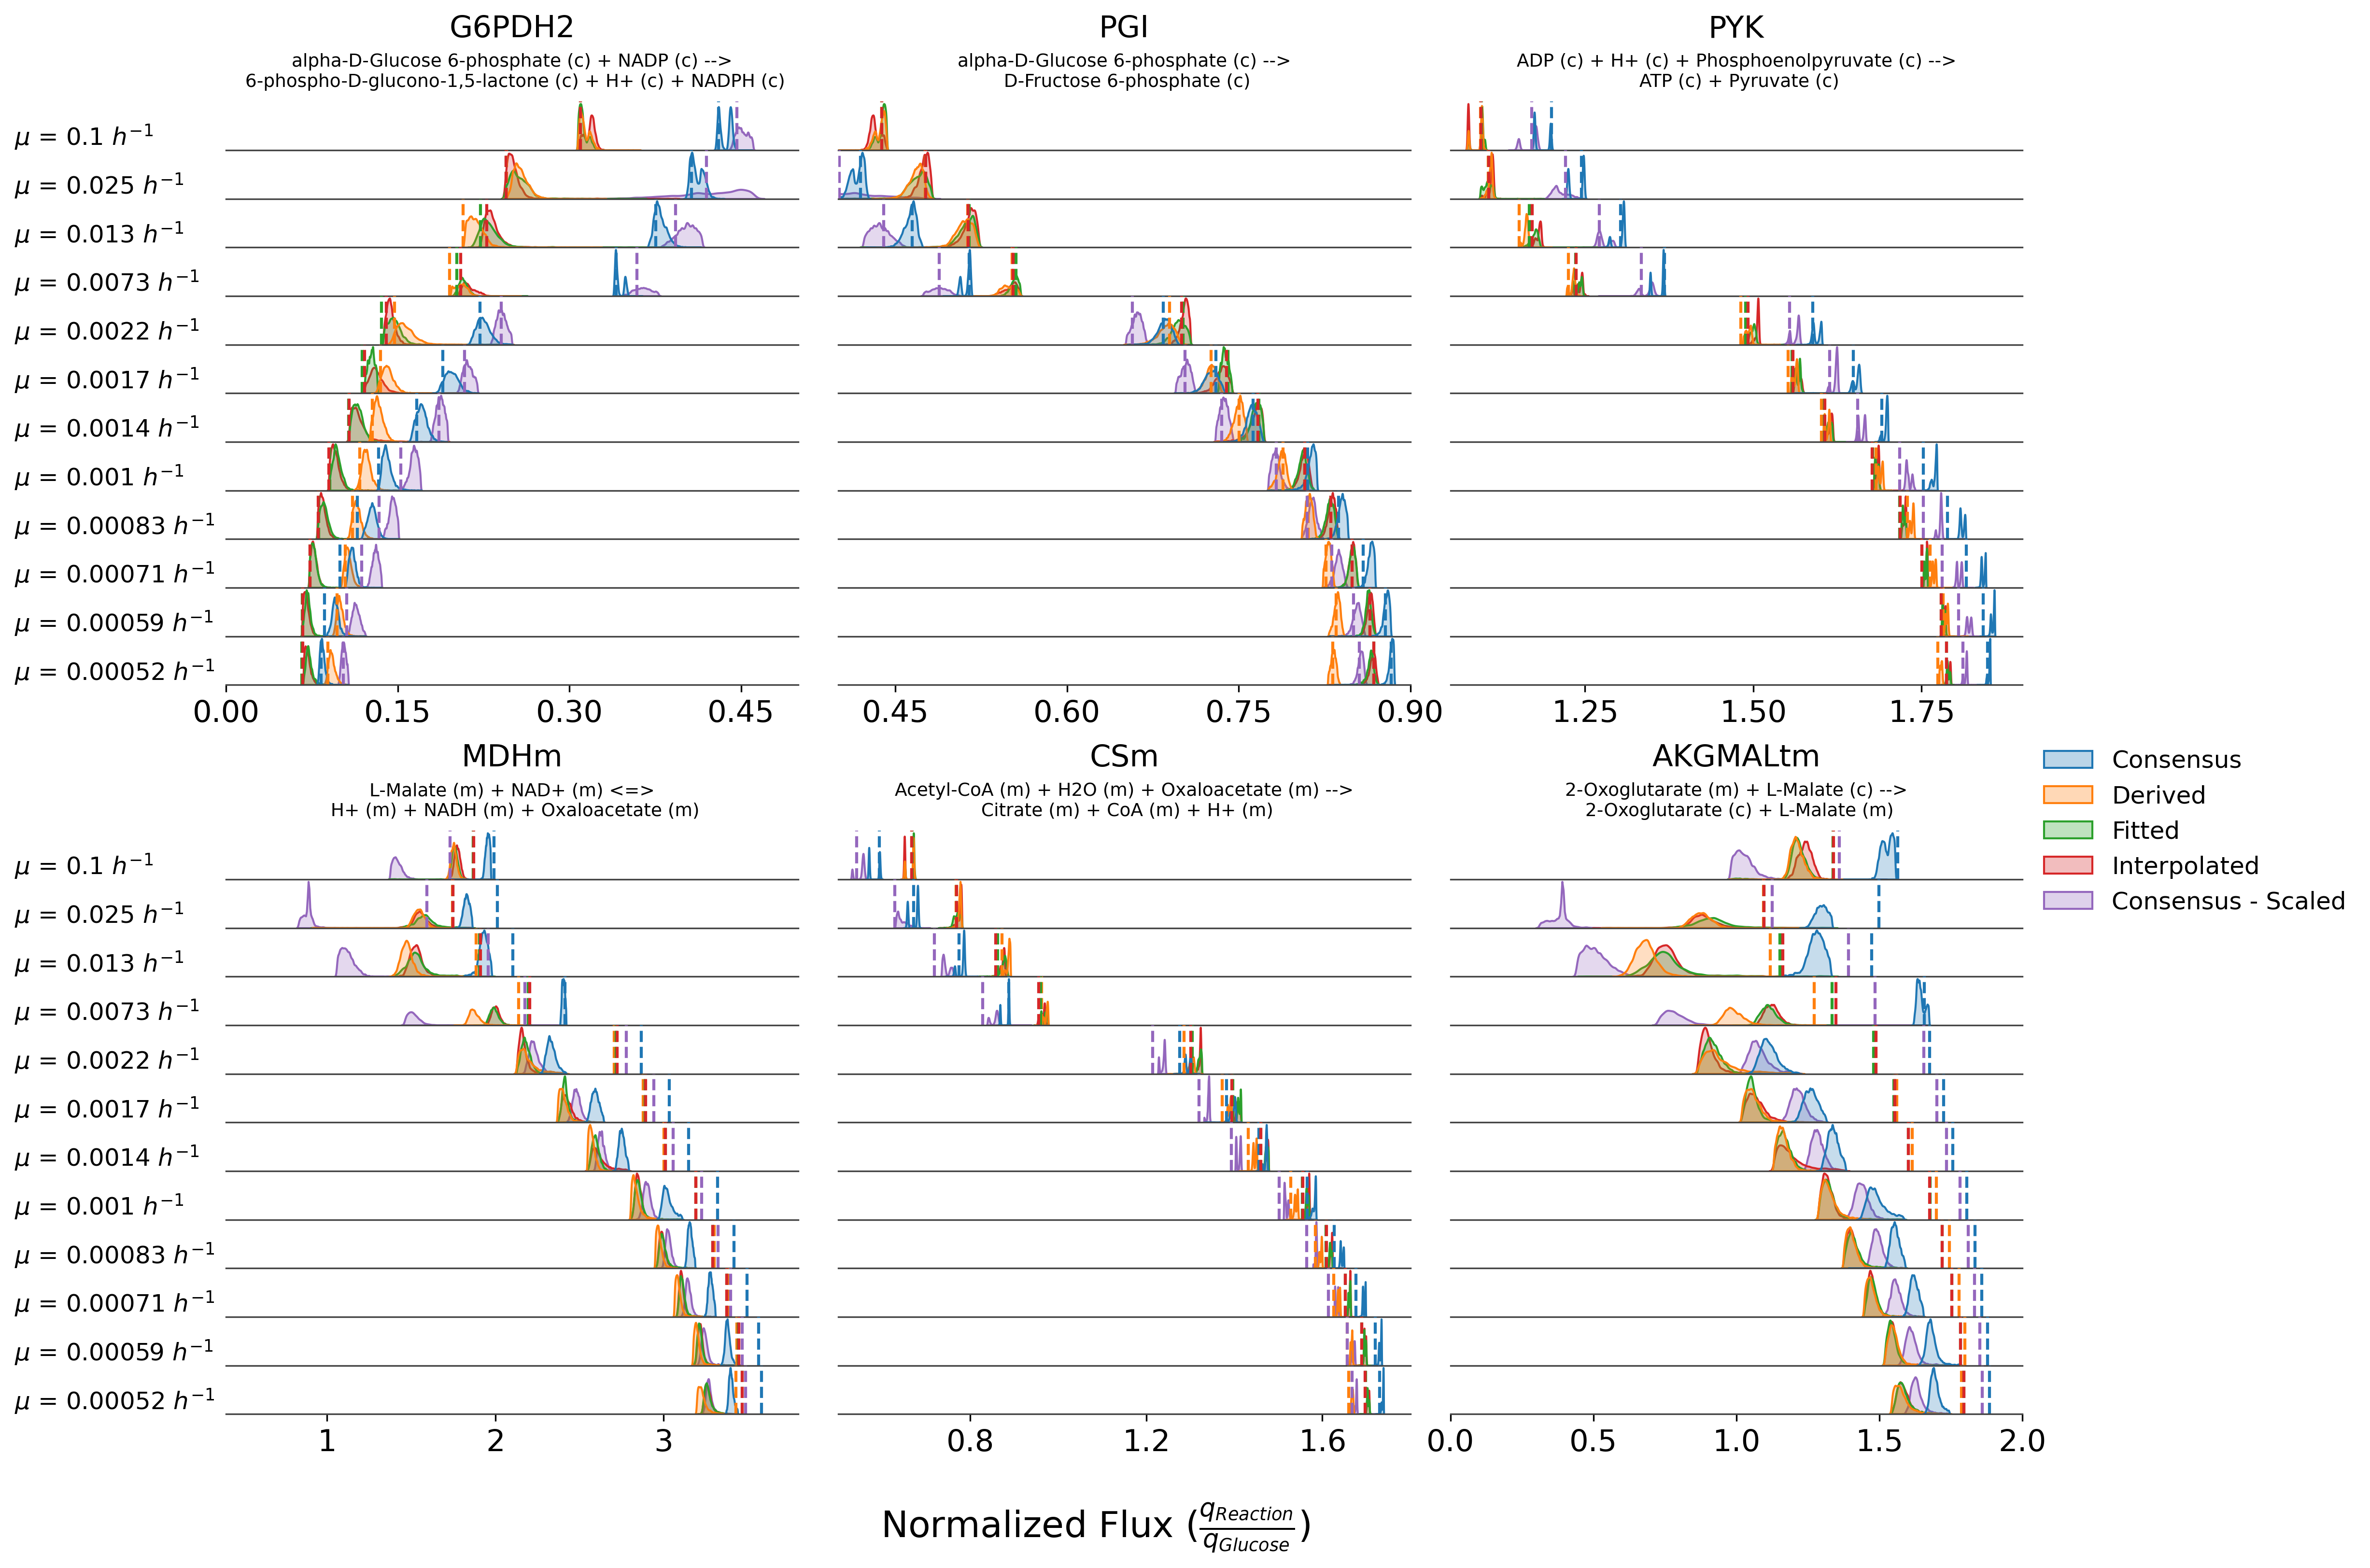

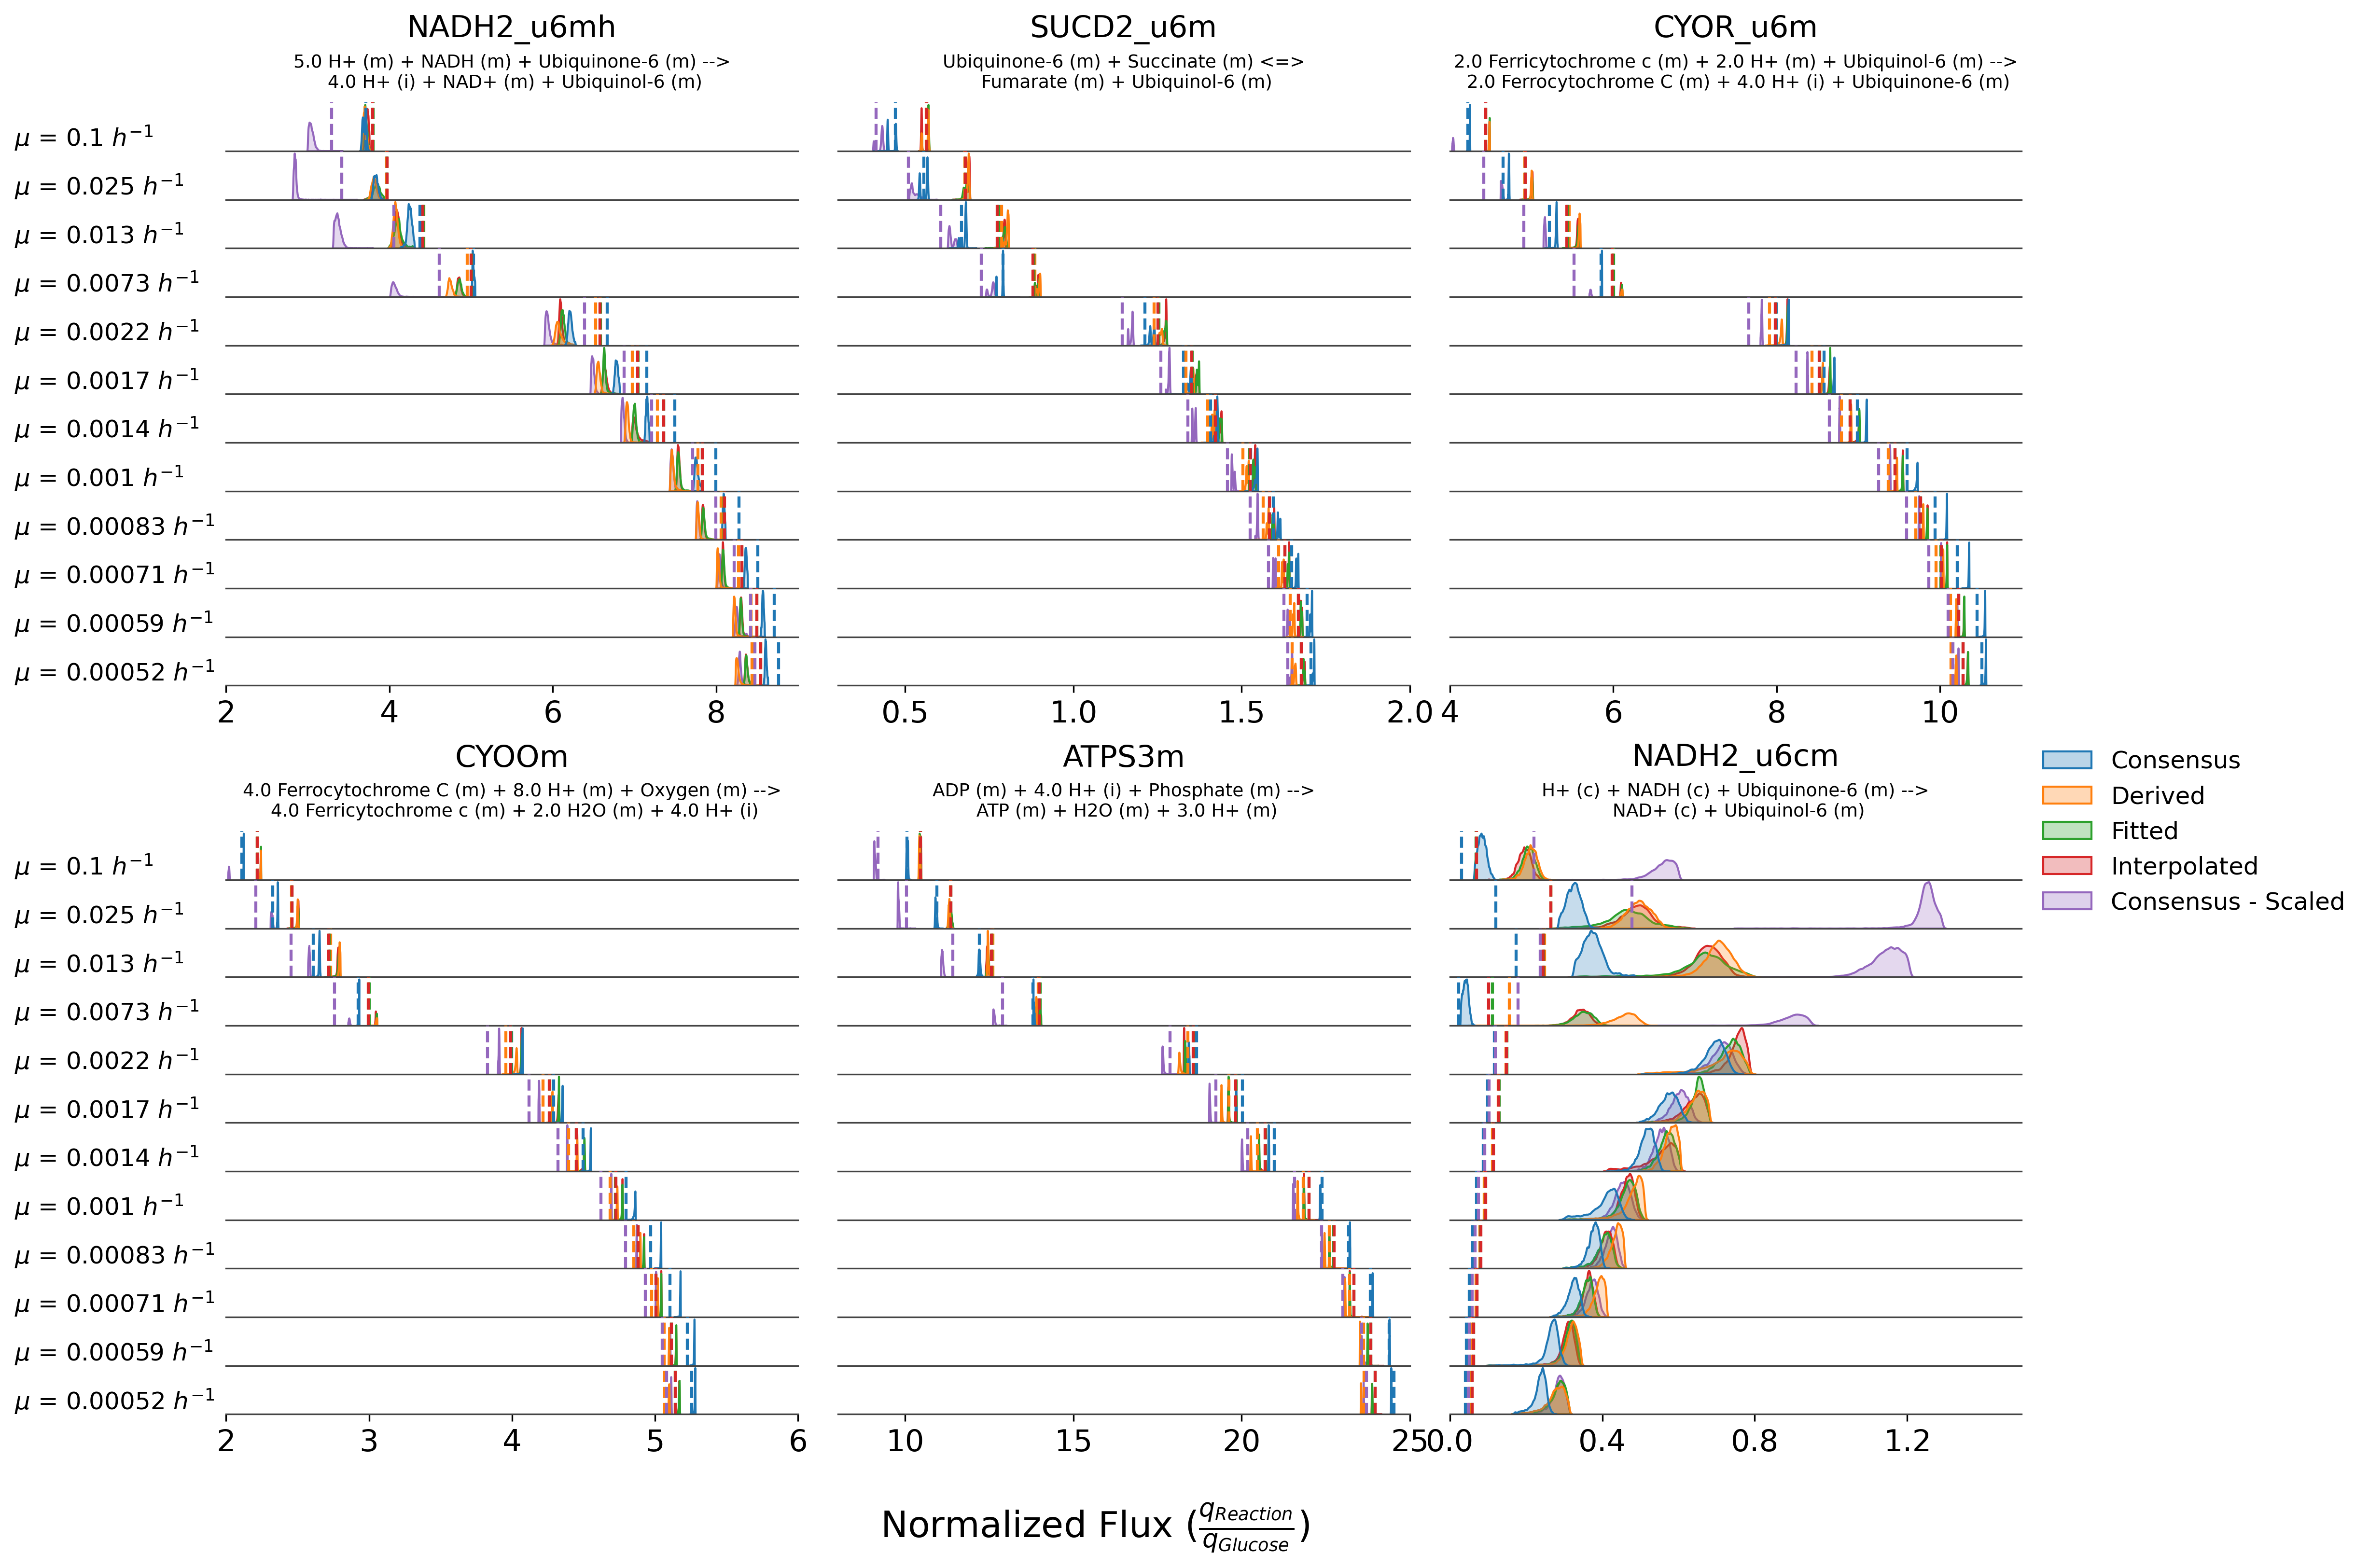

In [15]:
equation_names = ["Consensus","Derived", "Fitted", "Interpolated","ScaledConsensus"]

interesting_reactions = [("G6PDH2",0,0.5), ("PGI",0.4,0.9),("PYK",1.05,1.9),
                         ("MDHm", 0.4,3.8),("CSm", 0.5,1.8), ("AKGMALtm",0,2)]

plot_6_ridge(norm_chains_df, norm_pfba, interesting_reactions,"Gly&PPP", equation_names, model)

interesting_reactions = [("NADH2_u6mh",2,9),("SUCD2_u6m",0.3,2),
                         ("CYOR_u6m", 4,11),("CYOOm", 2,6),("ATPS3m", 8,25), ("NADH2_u6cm",0,1.5)]

plot_6_ridge(norm_chains_df, norm_pfba, interesting_reactions,"ETC",equation_names, model)


#### Percentage reduction on atp yield per glucose due to alternative NADH dehydrogenase

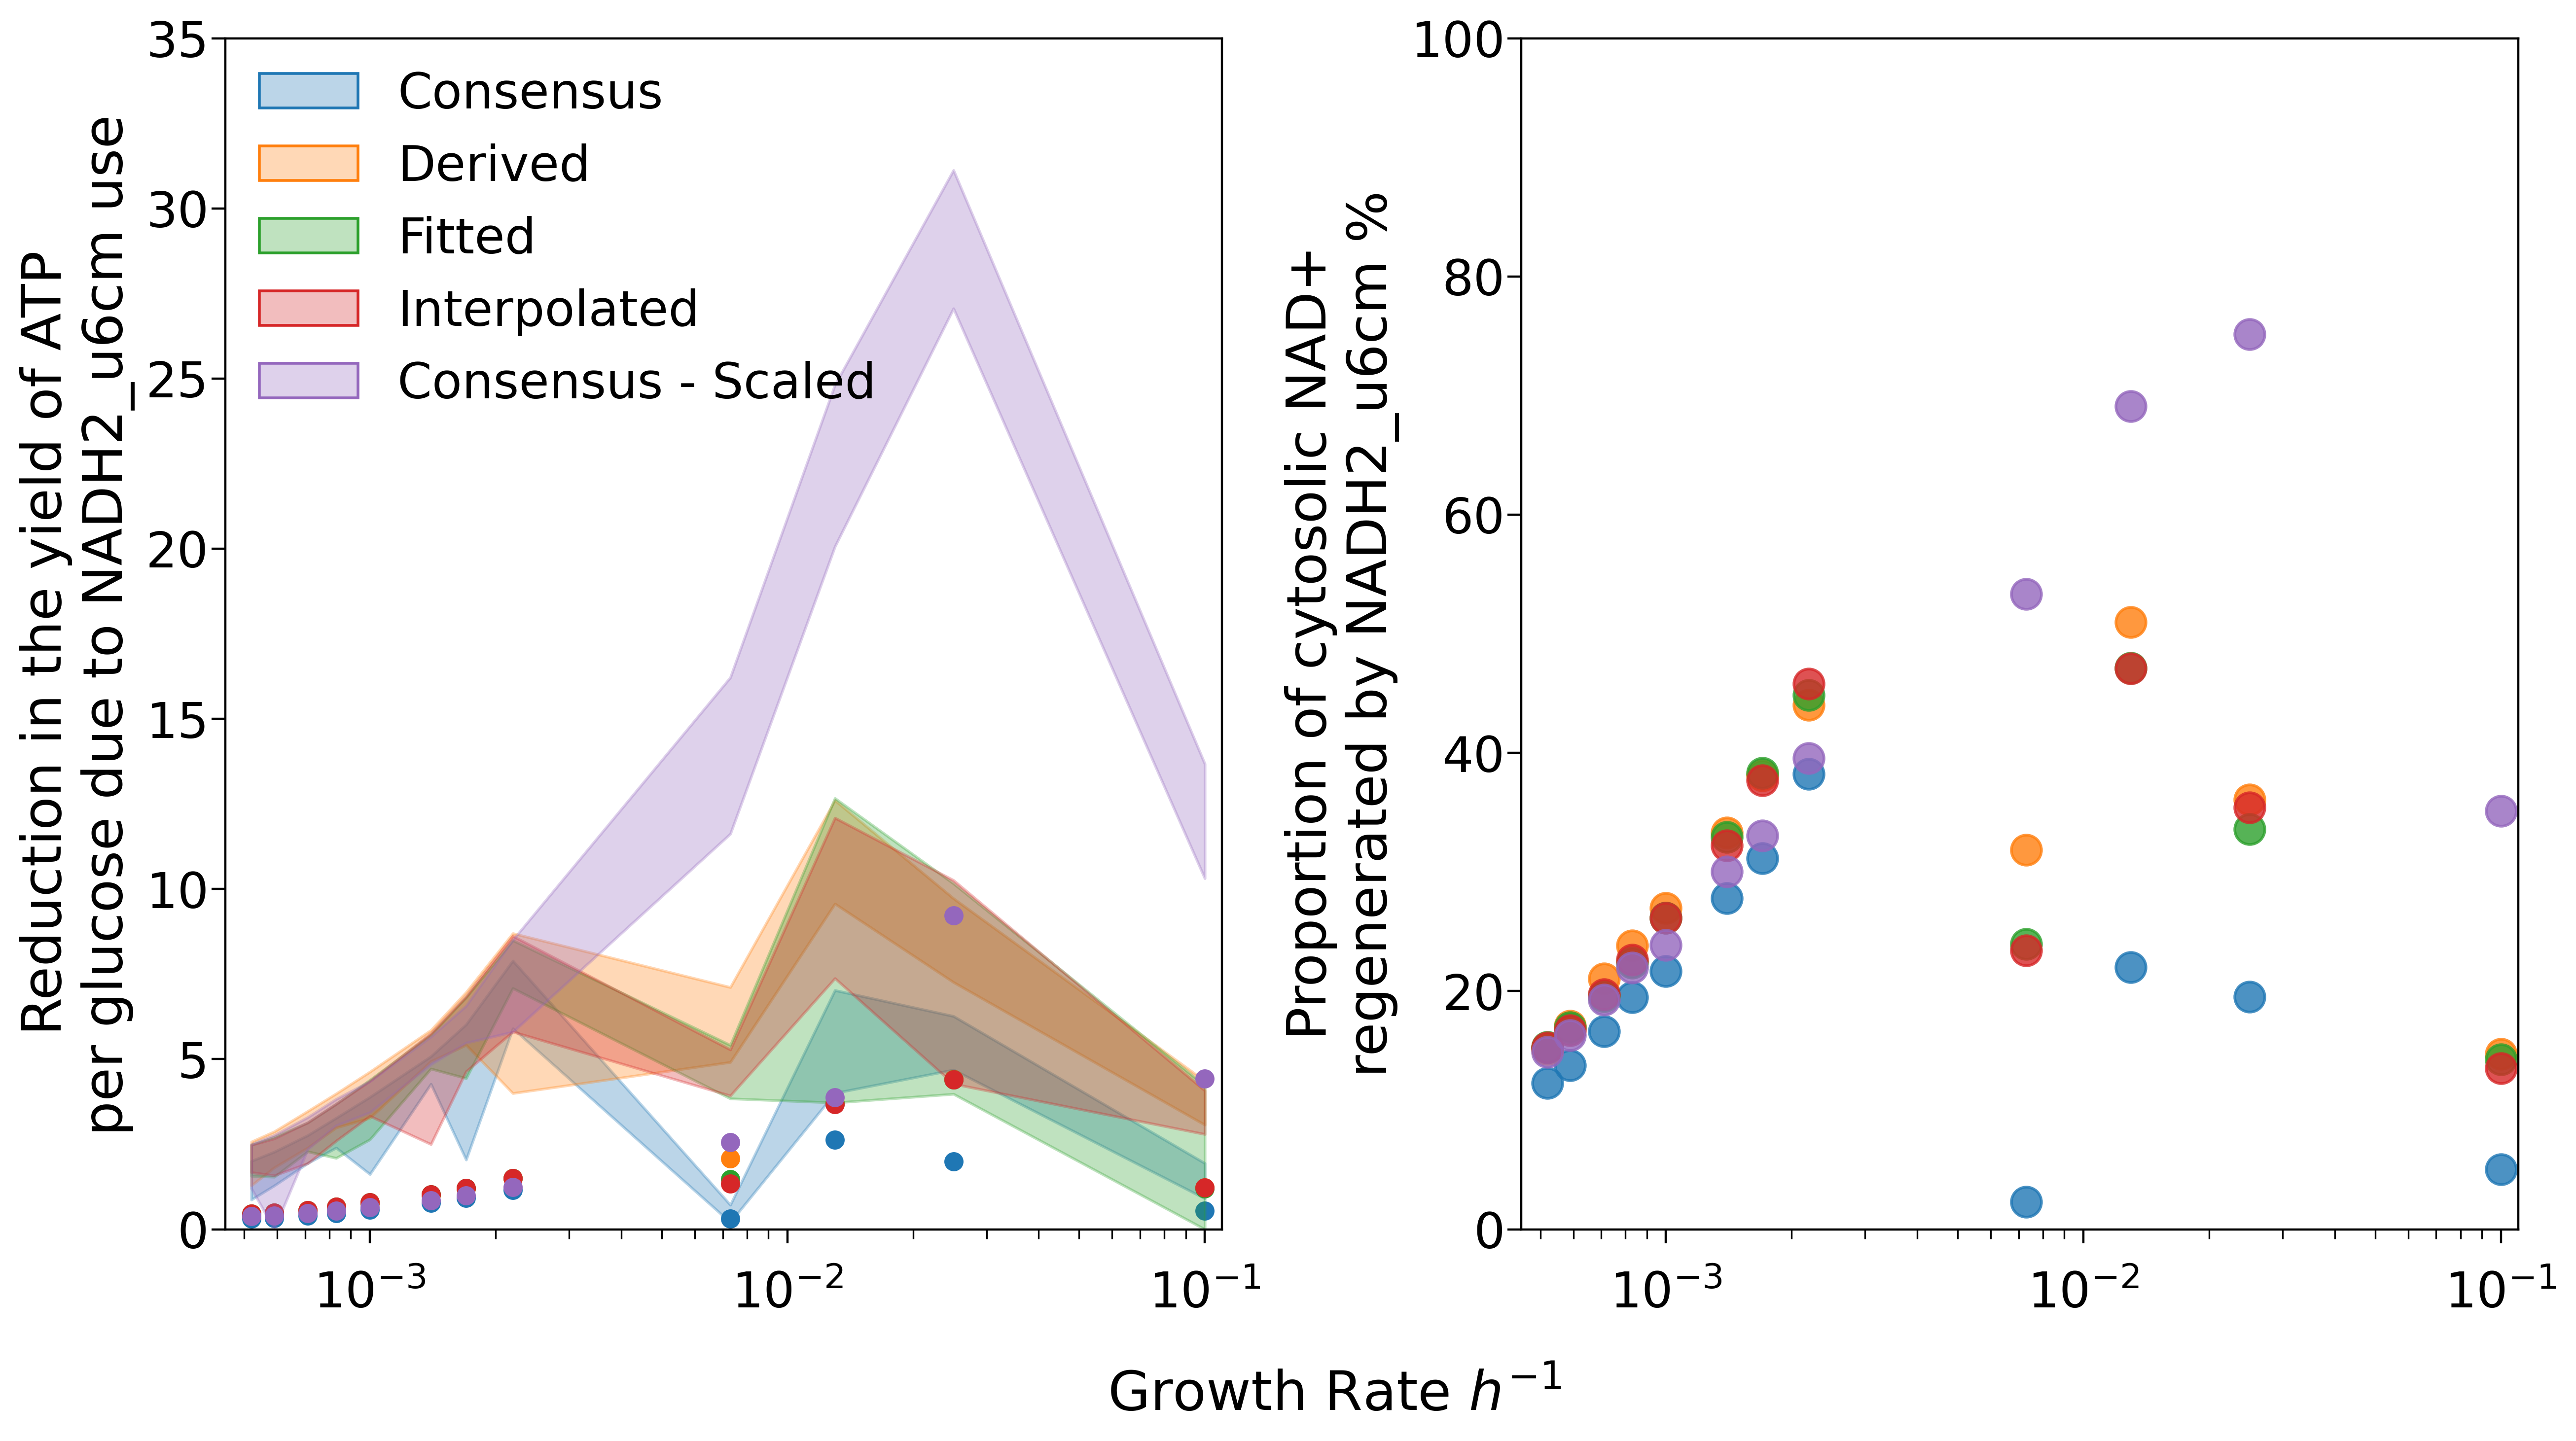

In [16]:
cmap = plt.cm.get_cmap('tab10', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
        
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,8),dpi=400)
# ax2 = ax.twinx()
frac_atp_yield = 0.66

alt_nadh_complex_i = norm_chains_df["NADH2_u6cm"].div(norm_chains_df["NADH2_u6mh"]).groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]).unstack(-1)
alt_nadh_complex_i = alt_nadh_complex_i*frac_atp_yield*100# (1-alt_nadh_complex_i*frac_atp_yield)*100#*frac_atp_yield#*= 100*frac_atp_yield
alt_nadh_complex_i = alt_nadh_complex_i.reset_index("Growth Rate")

alt_nadh_complex_i_pfba = norm_pfba["NADH2_u6cm"].div(norm_pfba["NADH2_u6mh"])
alt_nadh_complex_i_pfba = alt_nadh_complex_i_pfba*frac_atp_yield*100# (1-alt_nadh_complex_i_pfba*frac_atp_yield)*100
alt_nadh_complex_i_pfba = alt_nadh_complex_i_pfba.reset_index("Growth Rate")
alt_nadh_complex_i_pfba[0]

nad_supply = cof_rxn_supply2.loc["nad_c"].div(cof_rxn_supply2.loc["nad_c"].sum(axis=1),axis=0)
nad_supply = nad_supply.loc[:,~(nad_supply == 0).all()]*100
nad_supply = nad_supply.reset_index("Growth Rate")


for i, eqn in enumerate(equation_names):
    temp = alt_nadh_complex_i.loc[eqn]
    temp_pfba = alt_nadh_complex_i_pfba.loc[eqn]
    ax1.fill_between(temp["Growth Rate"].astype(float), temp[0.025], temp[0.975],alpha=0.3, color=color_list[i], label=eqn)
    ax1.scatter(temp_pfba["Growth Rate"].astype(float), temp_pfba[0], color=color_list[i])
    
    ax2.scatter(nad_supply.loc[eqn,"Growth Rate"].astype(float), nad_supply.loc[eqn,"NADH2_u6cm"], color=color_list[i], s=120,alpha=0.8)
    
[ax.set_xscale("log") for ax in [ax1, ax2]]
[ax.tick_params("y", labelsize=18, pad=1, length=5) for ax in [ax1, ax2]]
[ax.tick_params("x", labelsize=18, pad=10, length=5) for ax in [ax1, ax2]]
[ax.tick_params(which="minor",length=3.5) for ax in [ax1, ax2]]
[ax.set_xlim(0.00045,0.11) for ax in [ax1, ax2]]

ax1.set_ylim(0,35)
ax2.set_ylim(0,100)


labels = [eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled" for eqn in equation_names]       
legend_elements = [mpatches.Patch(edgecolor=cmap(i), label=eqn, facecolor=cmap(i)[:-1] + (0.3,)) for i, eqn in enumerate(labels)]
legend = ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.01,1.01), fontsize=18, frameon=False)

ax1.set_ylabel("Reduction in the yield of ATP \n per glucose due to NADH2_u6cm use", fontsize=20)
ax2.set_ylabel("Proportion of cytosolic NAD+ \nregenerated by NADH2_u6cm %", fontsize=20)

fig.text(0.5, 0.02, r"Growth Rate $h^{-1}$", ha='center', va='center', fontsize=20)

fig.subplots_adjust(hspace=0, wspace=0.3)
fig.savefig("../results/plots/ATPReduction_AltNADHDehydrogenase.png",
            bbox_inches='tight',transparent=True)

##### Plot cofactor production fluxes

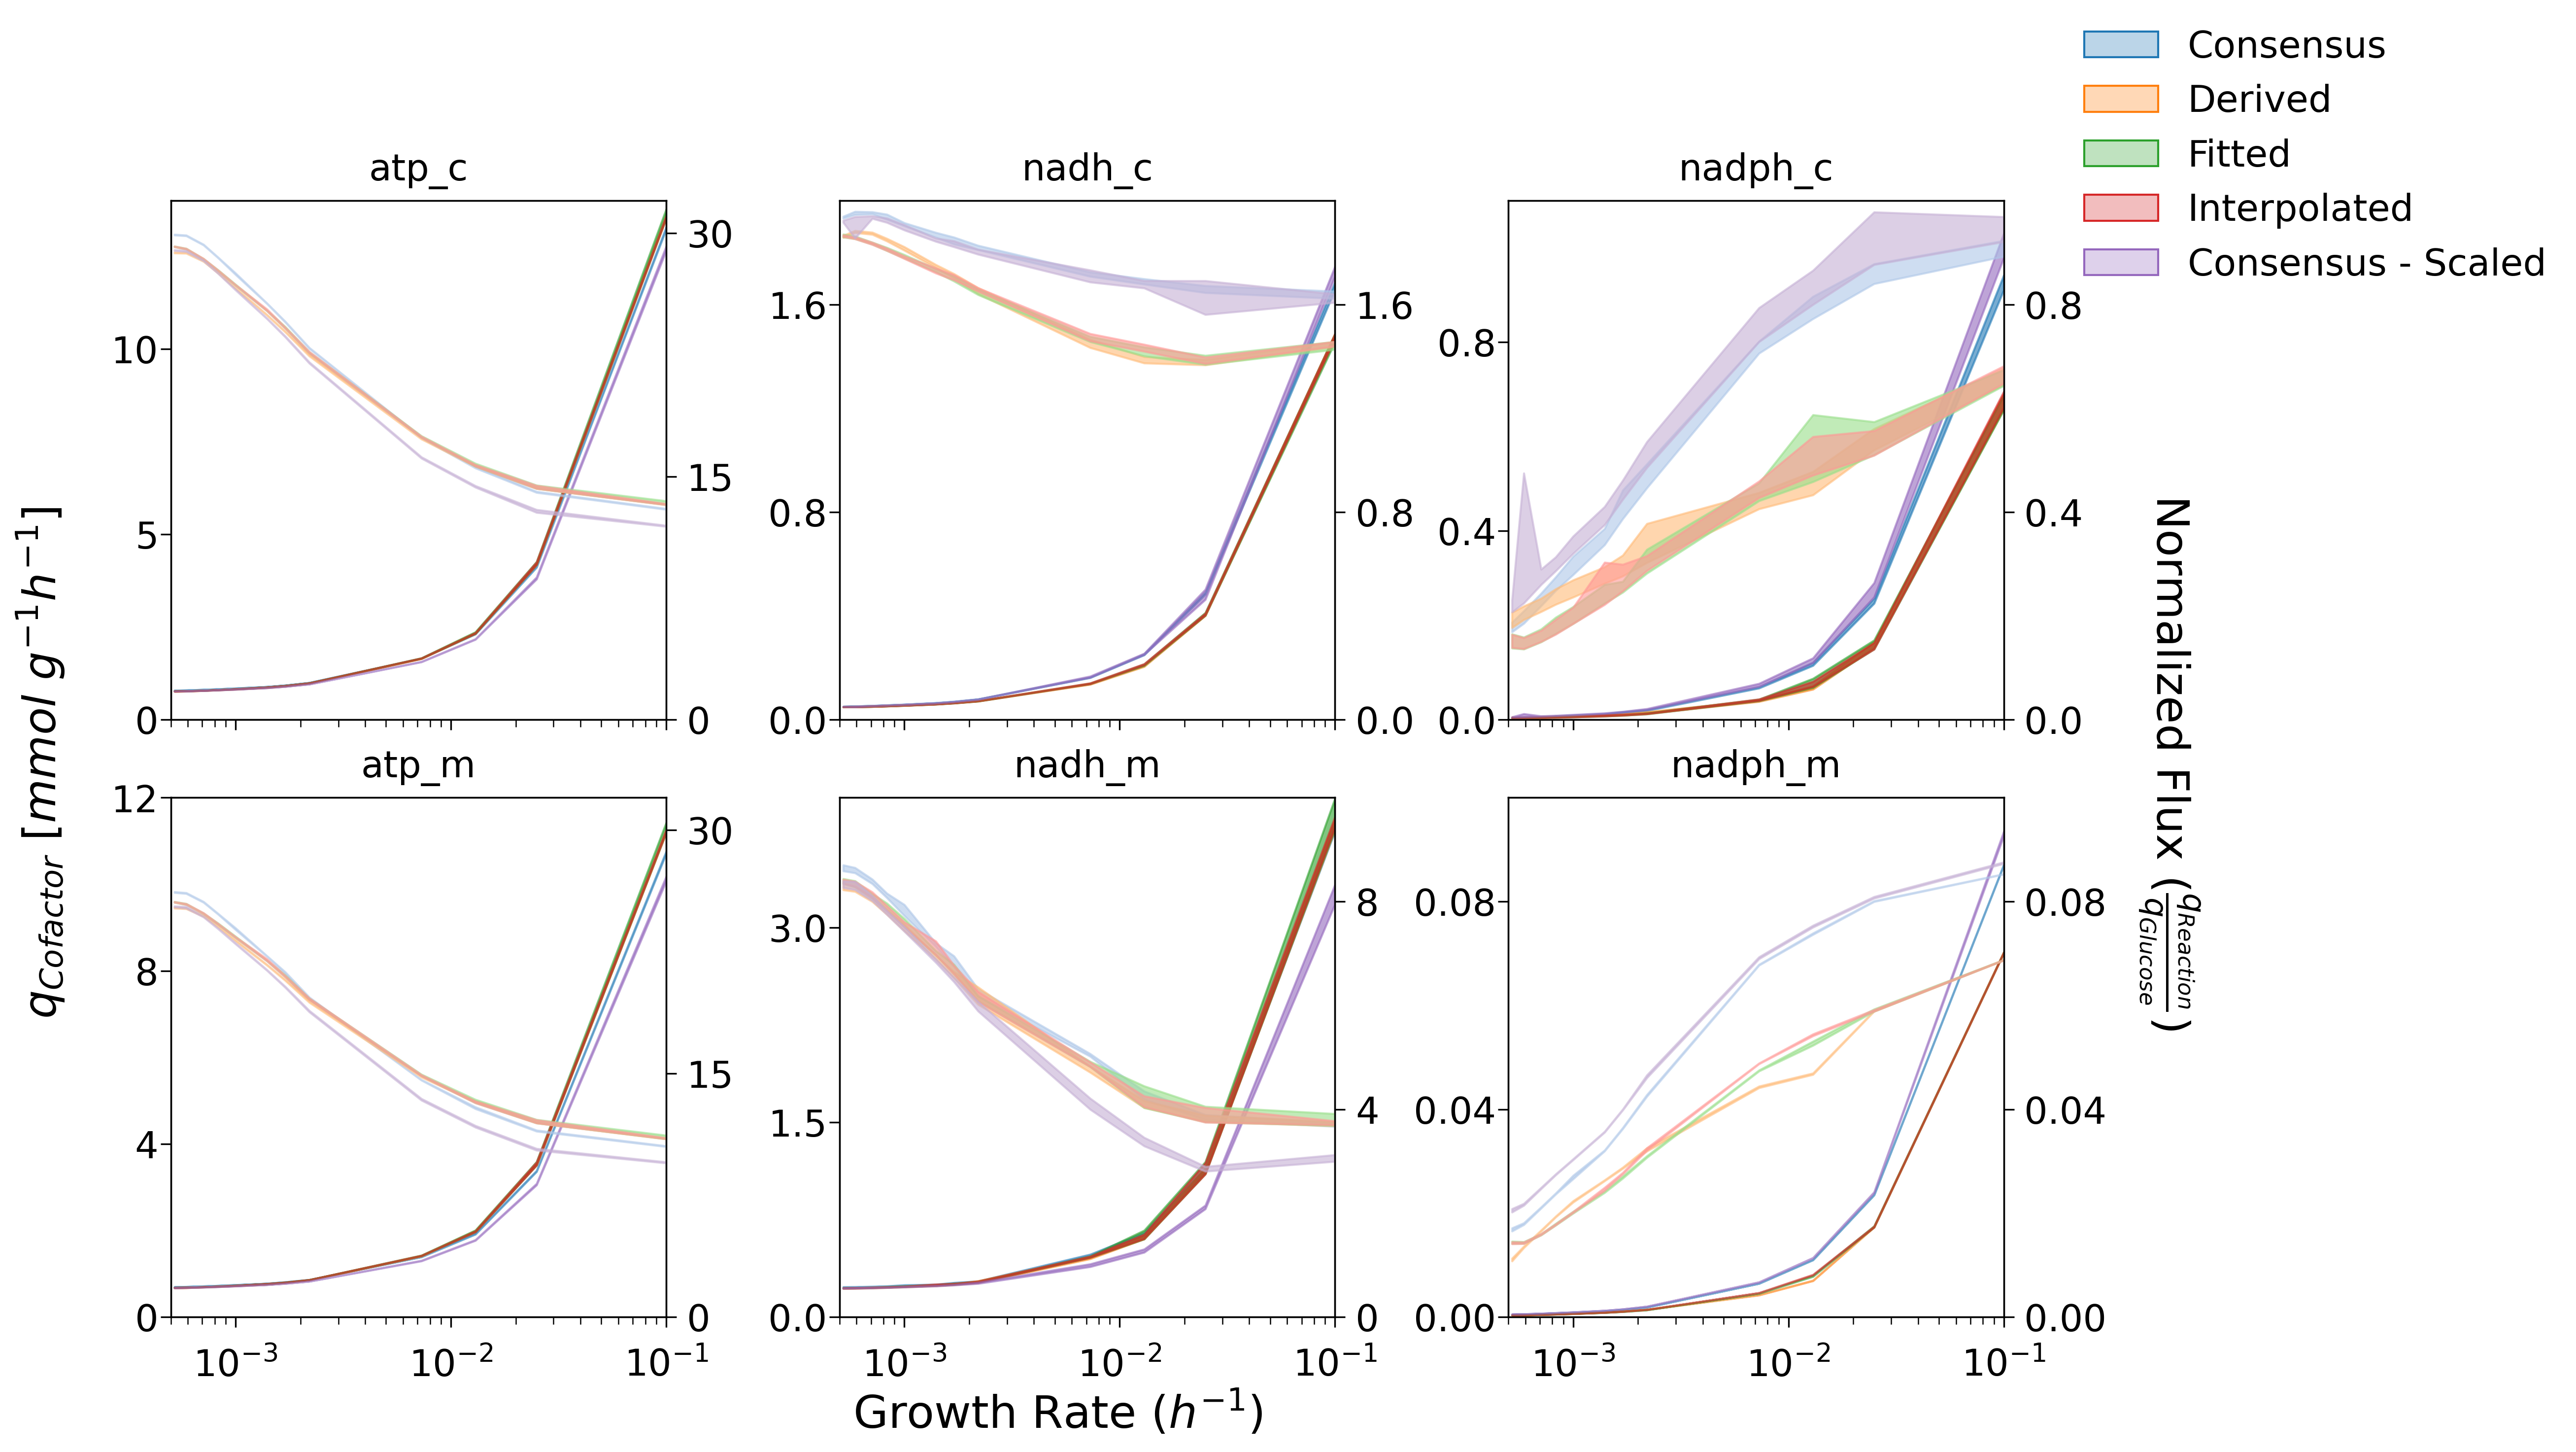

In [17]:
equation_names =  ["Consensus","Derived", "Fitted", "Interpolated","ScaledConsensus"]

interested_cofactors = [('atp_c',(0,14),(0,32)), 
                        ('nadh_c',(0,2),(0,2)), 
                        ('nadph_c', (0,1.1),(0,1)), 
                        ('atp_m', (0,12),(0,32)),
                        ('nadh_m', (0,4),(0,10)), 
                        ('nadph_m', (0,0.1),(0,0.1))]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10),dpi=300, sharex="col") # ) # 

cmap = plt.cm.get_cmap('tab20', 20)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

for i, (cof, ax_lims, ax2_lims) in enumerate(interested_cofactors):
    norm_slice = cofactors_norm_ranges.loc[cof]
    total_slice = cofactors_ranges.loc[cof]

    if i > 2:
        ax = axs[1,i-3]
    else:
        ax = axs[0,i]
    
    ax.set_xscale("log")
    ax2 = ax.twinx()
    
    for j, biomass in enumerate(equation_names):
        
        x = total_slice.columns.astype(float)
        uy = total_slice.loc[(biomass, 0.975),:]  # 0.9875),:] 
        ly = total_slice.loc[(biomass, 0.025),:]  #0.0125),:] 
        
        ax.fill_between(x, uy, ly,alpha=0.6, color=color_list[j*2], label=biomass, zorder=10)

        uy = norm_slice.loc[(biomass, 0.975),:]  # 0.9875),:] 
        ly = norm_slice.loc[(biomass, 0.025),:] # 0.0125),:] 
        ax2.fill_between(x, uy, ly,alpha=0.6, color=color_list[1+j*2], label=biomass)
    
    ax.set_ylabel("")
    ax2.set_ylabel("")

    ax.set_xlabel("", fontsize=40, labelpad=20)
    
    ax.tick_params("y", labelsize=18, pad=1, length=5)
    ax.tick_params("x", labelsize=18, pad=10, length=5)
    ax.tick_params(which="minor",length=3.5)
    ax2.tick_params(labelsize=18, pad=5, length=5)
    
    ax.set_title(cof, fontsize=18,pad=10)
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax2.yaxis.set_major_locator(MaxNLocator(3))

   
    ax.set_xlim(0.0005,0.1)
    ax.set_ylim(ax_lims)
    ax2.set_ylim(ax2_lims)
    
plt.subplots_adjust(wspace=0.35, hspace=0.15) #hspace=0.25)


labels = [eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled" for eqn in equation_names]       
legend_elements = [mpatches.Patch(edgecolor=cmap(i*2), label=eqn, facecolor=cmap(i*2)[:-1] + (0.3,)) for i, eqn in enumerate(labels)]
legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.92,0.91), fontsize=18, frameon=False)

fig.text(0.07, 0.5, r'$q_{Cofactor}$ $[mmol\ g^{{-1}} h^{{-1}}]$', ha='center', va='center', fontsize=22,rotation=90)
fig.text(0.97, 0.5, r'Normalized Flux ($\frac{q_{Reaction}}{q_{Glucose}}$)', ha='center', va='center', fontsize=22,rotation=270)
fig.text(0.5, 0.06, r'Growth Rate ($h^{-1}$)', ha='center', va='center', fontsize=22)

fig.savefig(f"../results/plots/Mu_vs_Cofactors.png",
            bbox_inches='tight',transparent=True)

#### Statistical comparisons 
- significant differences between biomass equation generation methods & at different growth rates
Use 1000 samples instead of the 5000 to reduce computational time

In [18]:
%%time

all_sp_stats_norm = pd.DataFrame()

data = DRinfo.loc[:,model_viab_cols]

comparisons = [("Consensus","ScaledConsensus"), ("Consensus","Derived"), ("Consensus", "Interpolated"), ("Consensus", "Fitted"),
               ("ScaledConsensus","Derived"), ("ScaledConsensus", "Interpolated"), ("ScaledConsensus", "Fitted"),
               ("Interpolated", "Derived"), ("Interpolated", "Fitted"),
               ("Derived", "Fitted")]


for comp in comparisons:

    first, second = comp
    
    comp_stats = []

    for name, values in data.iterrows():
        
        start = time.time()

        name = str(name)
        mu = values[0]
        df1 = pd.read_pickle(f"../results/sampling/{first}_{name}_T{optthin}.pkl.gz")
        df2 = pd.read_pickle(f"../results/sampling/{second}_{name}_T{optthin}.pkl.gz")

    
        shared_columns = list(set(df1.columns).intersection(df2.columns))
        df1 = df1.loc[:,shared_columns] 
        df2 = df2.loc[:,shared_columns] 

        mask = (df1.sum(axis=0) == 0)&(df1.sum(axis=0) == df2.sum(axis=0))
        
        df1 = df1.loc[:, ~mask]
        df2 = df2.loc[:, ~mask]
        
        df1 = df1.sample(1000)
        df2 = df2.sample(1000)

        rxn_names = df1.columns
        n_rxns = len(rxn_names) ### CHeck both have same number each time
        yield_rxn = 'Ex_glc_D'

        ix = df1.columns.get_loc(yield_rxn)
        
        df1 = df1.values
        df2 = df2.values
        

        rel_df1 = df1 * np.abs(1/df1[:,[ix]])
        rel_df2 = df2 * np.abs(1/df2[:,[ix]])

        index = pd.MultiIndex.from_product([[name], rxn_names])
        sp_stats = pd.DataFrame(columns = ['Reaction','U-val', 'M P-value', 'RBC', 'CLES', 'Rhat', 'VD-A', 'VD Magnitude',"Cliff's D"])

        for_pool = []
        for i in np.arange(0,n_rxns):
            rxn_name = rxn_names[i]
            col_df1 = rel_df1[:,i]
            col_df2 = rel_df2[:,i]
            for_pool.append([col_df1, col_df2, rxn_name])
        

        pool = Pool(processes=processes)
        all_series = pool.starmap(calcstats, for_pool)
        pool.close()
        
        sp_stats = pd.concat(all_series,axis=1).T
        
        reject, adj_p, alpha_sid, alpha_bon = multipletests(np.abs(sp_stats["M P-value"].values), method="bonferroni",alpha=0.05/2) ## two tailed, so divide by 2
        sp_stats["Reject"] = reject
        sp_stats["Adjusted-p"] = adj_p.astype(float)
        sp_stats["M P-value"] = sp_stats["M P-value"].astype(float)
        sp_stats["Growth Rate"] = sp_gr[name]
        # sp_stats["Sampling Point"] = name
        
        comp_stats.append(sp_stats)
    comp_df = pd.concat(comp_stats)
    comp_df["Comparisons"] = f"{first} vs {second}"
    # comp_df.set_index(["Comparisons", "Sampling Point","Reaction"], inplace=True)
    comp_df.set_index(["Comparisons", "Growth Rate","Reaction"], inplace=True)
        
        
    all_sp_stats_norm = all_sp_stats_norm.append(comp_df)
# all_sp_stats_norm.index.get_level_values("Sampling Point")
all_sp_stats_norm["Reaction Number"] = all_sp_stats_norm.groupby("Growth Rate").cumcount() + 1   
# all_sp_stats_norm["Reaction Number"] = all_sp_stats_norm.groupby("Sampling Point").cumcount() + 1   
all_sp_stats_norm["Abs Cliff's D"] = all_sp_stats_norm["Cliff's D"].abs()
all_sp_stats_norm["Rxn Subsystem"] = all_sp_stats_norm.index.get_level_values("Reaction").to_series().apply(lambda x: rgdict.get(x)).values
all_sp_stats_norm.to_csv(f"../results/dataframes/sampling/MethodComparisons_AllStatistics.csv")

CPU times: user 2min, sys: 3min 51s, total: 5min 52s
Wall time: 6min 21s


Median percentage of reactions differing across all comparisons

In [19]:
# rejects = all_sp_stats_norm.groupby(["Comparisons", "Sampling Point"])["Reject"].sum()#["Reject"]
# total_group = all_sp_stats_norm.groupby(["Comparisons", "Sampling Point"]).count().values[:,0]
rejects = all_sp_stats_norm.groupby(["Comparisons", "Growth Rate"])["Reject"].sum()#["Reject"]
total_group = all_sp_stats_norm.groupby(["Comparisons", "Growth Rate"]).count().values[:,0]
rejects = (rejects/total_group).to_frame().unstack()
print(f"Average of {round(100*rejects.stack().median().values[0],1)}% of reactions significantly differently dsitributed")
rejects.to_csv(f"../results/dataframes/sampling/MethodComparisons_MWURejects.csv")
rejects

Average of 72.5% of reactions significantly differently dsitributed


Reject                                \
Growth Rate                       0.00052   0.00059   0.00071   0.00083   
Comparisons                                                               
Consensus vs Derived             0.706186  0.657807  0.719358  0.731884   
Consensus vs Fitted              0.685201  0.686860  0.733219  0.750654   
Consensus vs Interpolated        0.669550  0.675164  0.725835  0.750656   
Consensus vs ScaledConsensus     0.710972  0.674915  0.761141  0.656627   
Derived vs Fitted                0.716482  0.697515  0.668342  0.723535   
Interpolated vs Derived          0.703671  0.649708  0.644635  0.722367   
Interpolated vs Fitted           0.634105  0.548904  0.577526  0.585689   
ScaledConsensus vs Derived       0.746114  0.650165  0.699647  0.678634   
ScaledConsensus vs Fitted        0.725171  0.670588  0.761525  0.681034   
ScaledConsensus vs Interpolated  0.732468  0.698529  0.722621  0.692175   

                                                                         \
Growth Rate                         0.001    0.0014    0.0017    0.0022   
Comparisons                                                               
Consensus vs Derived             0.735164  0.725953  0.747930  0.732026   
Consensus vs Fitted              0.763717  0.749781  0.706912  0.716418   
Consensus vs Interpolated        0.731556  0.723627  0.717489  0.758879   
Consensus vs ScaledConsensus     0.717637  0.660194  0.726606  0.744444   
Derived vs Fitted                0.704325  0.730045  0.697026  0.707865   
Interpolated vs Derived          0.716060  0.763324  0.663014  0.725762   
Interpolated vs Fitted           0.674956  0.622403  0.620975  0.708218   
ScaledConsensus vs Derived       0.722174  0.749534  0.757435  0.759124   
ScaledConsensus vs Fitted        0.754156  0.759344  0.762523  0.735348   
ScaledConsensus vs Interpolated  0.705779  0.733151  0.744505  0.767035   

                                                                         
Growth Rate                        0.0073     0.013     0.025       0.1  
Comparisons                                                              
Consensus vs Derived             0.800570  0.746198  0.779183  0.779167  
Consensus vs Fitted              0.720461  0.750711  0.772381  0.794764  
Consensus vs Interpolated        0.745956  0.735119  0.782274  0.804188  
Consensus vs ScaledConsensus     0.745472  0.745491  0.798521  0.813347  
Derived vs Fitted                0.749277  0.693182  0.708748  0.506626  
Interpolated vs Derived          0.767308  0.710983  0.440796  0.661570  
Interpolated vs Fitted           0.710345  0.659266  0.671246  0.725051  
ScaledConsensus vs Derived       0.770934  0.705769  0.788027  0.782038  
ScaledConsensus vs Fitted        0.793922  0.737500  0.792776  0.805274  
ScaledConsensus vs Interpolated  0.742555  0.798202  0.830171  0.784758

- Percentage of reactions that had a large effect size in a comparison
Note, that between 5% and 10% of reactions had a large effect size for the C0.1 and 0.0 sampling points for the Derived, Fitted and Inteprolated despite the fact the biomass equation is the same. This is largely due to random smapling effecs

In [20]:
# large = (all_sp_stats_norm["VD Magnitude"] == "large").groupby(["Comparisons", "Sampling Point"]).sum()
large = (all_sp_stats_norm["VD Magnitude"] == "large").groupby(["Comparisons", "Growth Rate"]).sum()
large = (large/total_group).to_frame().unstack()
print(f"Average of {round(100*large.stack().median().values[0],1)}% of reactions demonstrate a large effect size")
large.to_csv(f"../results/dataframes/sampling/MethodComparisons_LargeEffects.csv")
large

Average of 46.1% of reactions demonstrate a large effect size


VD Magnitude                                \
Growth Rate                          0.00052   0.00059   0.00071   0.00083   
Comparisons                                                                  
Consensus vs Derived                0.464777  0.429402  0.395604  0.466486   
Consensus vs Fitted                 0.443969  0.452218  0.485370  0.452485   
Consensus vs Interpolated           0.447232  0.407895  0.462214  0.436570   
Consensus vs ScaledConsensus        0.471008  0.407850  0.478610  0.427711   
Derived vs Fitted                   0.466268  0.440446  0.434673  0.451444   
Interpolated vs Derived             0.461538  0.417014  0.421459  0.438642   
Interpolated vs Fitted              0.216795  0.220067  0.250000  0.251767   
ScaledConsensus vs Derived          0.487910  0.415842  0.451413  0.454466   
ScaledConsensus vs Fitted           0.446062  0.442857  0.489362  0.457759   
ScaledConsensus vs Interpolated     0.423377  0.414216  0.460503  0.411866   

                                                                         \
Growth Rate                         0.001    0.0014    0.0017    0.0022   
Comparisons                                                               
Consensus vs Derived             0.478299  0.463702  0.479301  0.457516   
Consensus vs Fitted              0.465487  0.449694  0.482028  0.460821   
Consensus vs Interpolated        0.469333  0.443766  0.452915  0.476636   
Consensus vs ScaledConsensus     0.464813  0.450132  0.492661  0.453704   
Derived vs Fitted                0.426302  0.461883  0.383829  0.446629   
Interpolated vs Derived          0.448980  0.453478  0.424658  0.469067   
Interpolated vs Fitted           0.310835  0.271003  0.304508  0.393352   
ScaledConsensus vs Derived       0.449606  0.490689  0.505576  0.483577   
ScaledConsensus vs Fitted        0.448819  0.466727  0.499072  0.500000   
ScaledConsensus vs Interpolated  0.464098  0.460838  0.481685  0.518416   

                                                                         
Growth Rate                        0.0073     0.013     0.025       0.1  
Comparisons                                                              
Consensus vs Derived             0.523267  0.522814  0.538911  0.564583  
Consensus vs Fitted              0.497598  0.514692  0.553333  0.562304  
Consensus vs Interpolated        0.490961  0.538690  0.523121  0.596859  
Consensus vs ScaledConsensus     0.495710  0.562124  0.556377  0.600626  
Derived vs Fitted                0.449373  0.457386  0.163022  0.082569  
Interpolated vs Derived          0.455769  0.487476  0.142289  0.171254  
Interpolated vs Fitted           0.412808  0.397683  0.092247  0.153768  
ScaledConsensus vs Derived       0.507218  0.547115  0.563297  0.596367  
ScaledConsensus vs Fitted        0.559354  0.514423  0.586502  0.583164  
ScaledConsensus vs Interpolated  0.517771  0.590410  0.577799  0.598352

##### Enrichment analysis on the different subsystems to determine where the significant changes occured

In [21]:
rgdict = {}
for g in model.groups:
    for r in g.members:
        rgdict[r.id] = g.id.title()
        
subsystem_df = pd.DataFrame.from_dict(rgdict, orient="index").reset_index()
subsystem_df = subsystem_df.rename(columns={"index":"Rxn", 0:"Subsystem"})



In [22]:
all_output = []


for comparison in large.index:
    for sp in large.columns.get_level_values(1):
        
        ## using enrich function in CBModellingFuncs
        temp = all_sp_stats_norm.loc[(comparison, sp),"VD Magnitude"]
        output = enrich(temp[temp == "large"].index, subsystem_df["Rxn"].to_list(), subsystem_df) 
        if comparison == f"{first} vs {second}" and sp ==name:
            save = output
        all_output.extend(output.loc[output["adj_pval"] < 0.05, "Subsystem annotation"].to_list())
        
number_enriched = pd.Series(all_output).value_counts().to_frame().rename(columns={0:"Counts"})
number_enriched["Fraction"] = number_enriched["Counts"]/(large.shape[0]*large.shape[1])

number_enriched.to_csv(f"../results/dataframes/sampling/MethodComparisons_EnrichedPathways.csv")

number_enriched

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Counts  Fraction
Sphingolipid Metabolism                                114  0.950000
Sterol Metabolism                                      114  0.950000
Histidine Metabolism                                   112  0.933333
Quinone Biosynthesis                                   110  0.916667
Pentose Phosphate Pathway                              107  0.891667
Porphyrin And Chlorophyll Metabolism                   100  0.833333
Fatty Acid Biosynthesis                                 99  0.825000
Citric Acid Cycle                                       85  0.708333
Transport, Er                                           83  0.691667
Valine, Leucine, And Isoleucine Metabolism              65  0.541667
Glycolysis/Gluconeogenesis                              62  0.516667
Riboflavin Metabolism                                   61  0.508333
Pantothenate And Coa Biosynthesis                       59  0.491667
Folate Metabolism                                       58  0.483333
Amino Sugar And Nucleotide Sugar Metabolism             40  0.333333
Methionine Metabolism                                   36  0.300000
Cysteine Metabolism                                     20  0.166667
Thiamine Metabolism                                     20  0.166667
Transport, Golgi Apparatus                              18  0.150000
Alanine And Aspartate Metabolism                        16  0.133333
Pyridoxine Metabolism                                   15  0.125000
Nucleotide Metabolism                                   13  0.108333
Glyoxylate And Dicarboxylate Metabolism                 13  0.108333
Biomass Composition                                     12  0.100000
Arginine And Proline Metabolism                         11  0.091667
Other Amino Acid Metabolism                              9  0.075000
Oxidative Phosphorylation                                8  0.066667
Nad Biosynthesis                                         7  0.058333
Tyrosine, Tryptophan, And Phenylalanine Metabolism       5  0.041667
Threonine And Lysine Metabolism                          5  0.041667
Pyruvate Metabolism                                      5  0.041667
Transport, Mitochondrial                                 4  0.033333
Carbohydrate Metabolism                                  4  0.033333
Vitamin And Cofactor Biosynthesis                        2  0.016667
Glycerolipid Metabolism                                  2  0.016667
Phospholipid Metabolism                                  2  0.016667
Glutamate Metabolism                                     2  0.016667
Glycine And Serine Metabolism                            1  0.008333

### Additional analysis
- Not included in manuscript

##### Alternative plot of the 12 reactions. Flux yields and flux vs growth rate

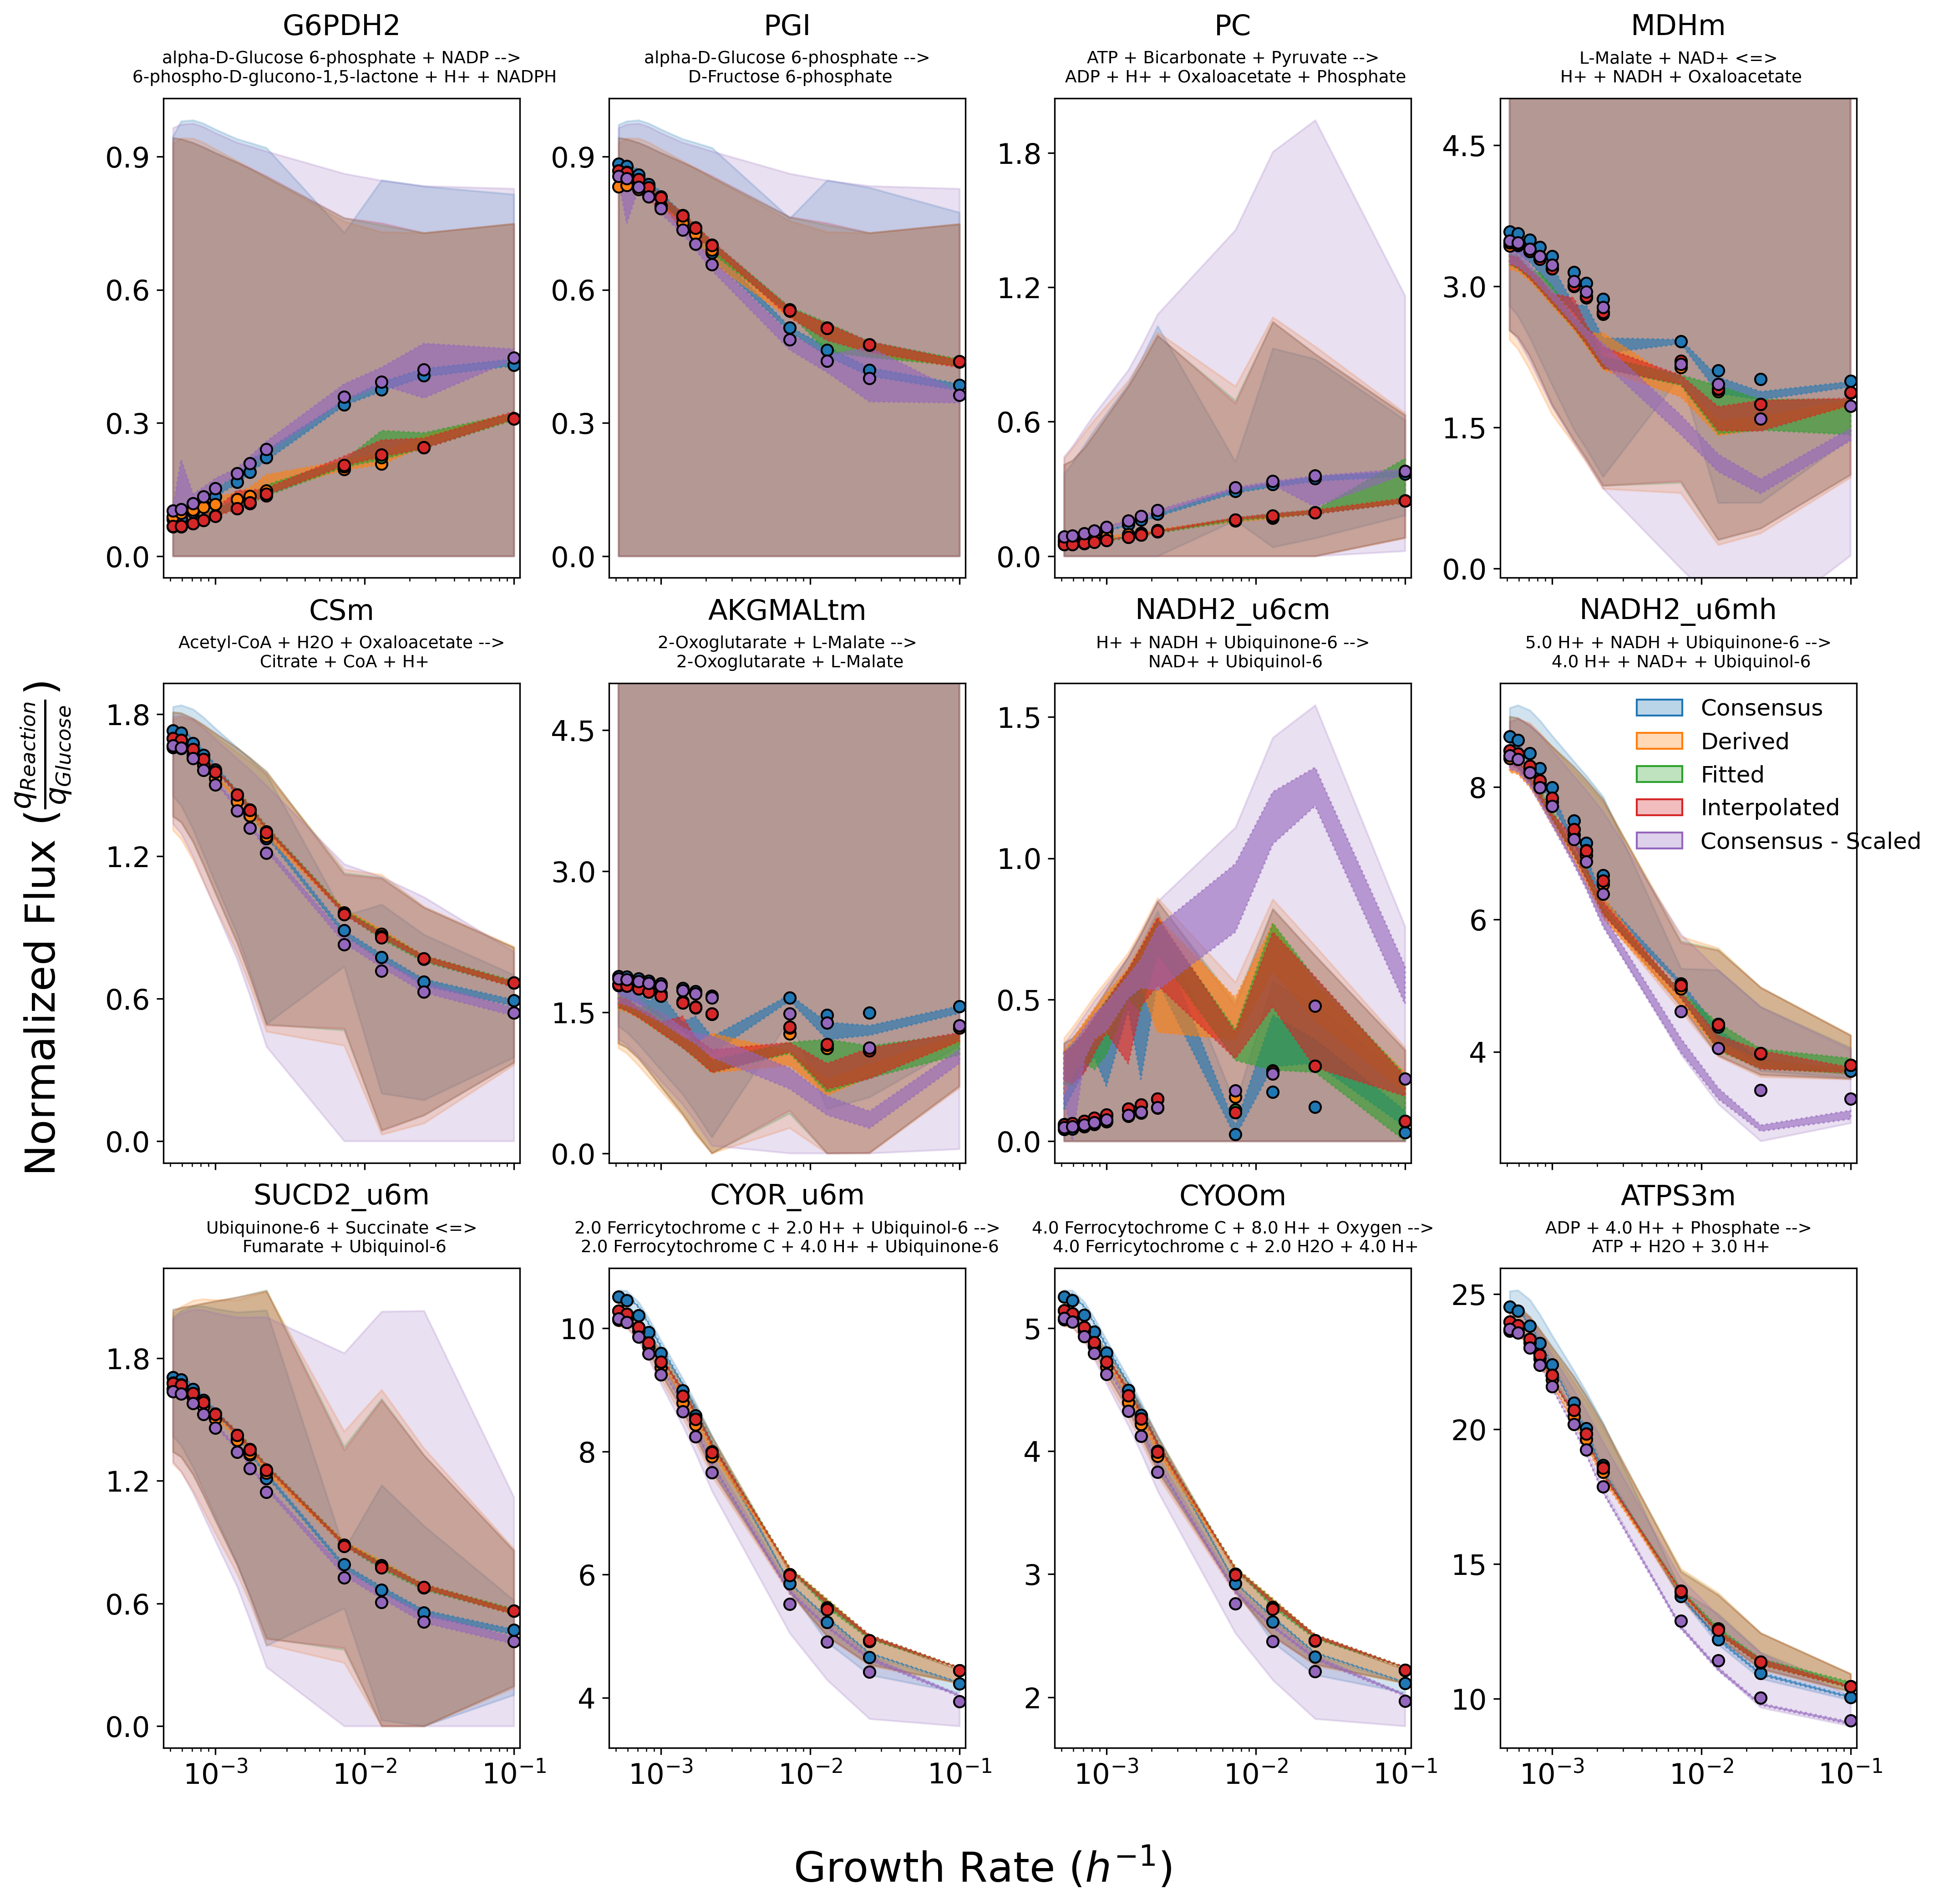

In [23]:
def plot_12_reactions(interesting_reactions,out_name,biomass_equations, quants, fva, pfba):
    
    number_sps = len(quants.index.get_level_values("Time").unique()) #norm_chains.Time.unique())

    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,16),dpi=300, sharex="col") # ) # 

    cmap = plt.cm.get_cmap('tab10', 10)
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    for i, (rxn,lb,ub) in enumerate(interesting_reactions):

        if i < 4:
            ax = axs[0,i]
        elif i < 8:
            ax = axs[1,i-4]
        else:
            ax = axs[2,i-8]
            
        plotting_fluxes(ax, rxn, quants, fva, pfba,color_list=color_list,biomass=biomass_equations)
        ax.set_xscale("log")
        if rxn in ["AKGMALtm", "MDHm"]:
            ax.set_ylim(-0.1, 5)
        # ax.set_ylim(lb, ub)
        ax.set_xlim(4.5e-4,0.11)
        from matplotlib.ticker import MultipleLocator, MaxNLocator
        ax.yaxis.set_major_locator(MaxNLocator(4))

        string = model.reactions.get_by_id(rxn).build_reaction_string(True)
        if string.find(">") > -1:
            string = string.split(">")
            string = (">\n").join(string)
        elif string.rfind("-") > -1:
            string = string.rsplit("-",1)
            string = ("-\n").join(string)


        ax.set_xlabel("")
        ax.tick_params(labelsize= 15)

        ax.text(0.5, 1.12, rxn, fontsize=15, transform = ax.transAxes,horizontalalignment='center',verticalalignment='bottom') 
        ax.text(0.5, 1.1, string, fontsize=9, transform = ax.transAxes,horizontalalignment='center',verticalalignment='top')  
        

    import matplotlib.patches as mpatches
    plt.subplots_adjust(wspace=0.25, hspace=0.22) #hspace=0.25)


    legend_elements = [mpatches.Patch(edgecolor=cmap(k), label=eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled", 
                                      facecolor=cmap(k)[:-1] + (0.3,)) for k, eqn in enumerate(biomass_equations)]
   
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.79,0.57), fontsize=12, frameon=False)

    fig.text(0.07, 0.5, r'Normalized Flux ($\frac{q_{Reaction}}{q_{Glucose}}$)', ha='center', va='center', fontsize=22,rotation=90)
    fig.text(0.5, 0.07, r'Growth Rate ($h^{-1}$)', ha='center', va='center', fontsize=22)

    fig.savefig(f"../results/plots/FluxYieldAll.png",
            bbox_inches='tight',transparent=True)  
    
def plotting_fluxes(ax,rxn, sampling_data, fva_data, pfba_data, color_list=None, biomass=None):
    if biomass == None:
        biomass = ["Dynamic", "Consensus"]
    elif type(biomass) != list:
        biomass = list(biomass)
    
    if color_list == None:
        cmap = plt.cm.get_cmap('tab10', 10)
        color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
    
    for i, bio in enumerate(biomass):
        
        col = color_list[i]
        
        fva_ranges = fva_data.loc[bio].sort_index(level=1)
        samples = sampling_data.loc[bio].sort_index(level=1)
        flux = pfba_data.loc[bio].sort_index(level=1)
        
        ax.fill_between(fva_ranges.index.get_level_values("Growth Rate").astype(float),
                        fva_ranges.loc[:,(rxn, "minimum") ],
                        fva_ranges.loc[:,(rxn, "maximum") ],
                        alpha=0.2,zorder=0, color=col)
        
        ax.fill_between(samples.index.get_level_values("Growth Rate").astype(float),
                        samples.loc[:,(rxn, 0.025) ],
                        samples.loc[:,(rxn, 0.975) ],
                        alpha=0.6, zorder=5, color=col, linestyle=":",edgecolors=col)
        
        ax.scatter(flux.loc[:,rxn].index.get_level_values("Growth Rate").astype(float),
                   flux.loc[:,rxn],zorder=10, color=col, edgecolors="black")


interesting_reactions = [("G6PDH2",0,0.5), ("PGI",0.4,0.9),("PC",0,1),
                         ("MDHm", 0.4,3.8),("CSm", 0.5,1.8), ("AKGMALtm",0,2),
                         ("NADH2_u6cm",0,1.5),("NADH2_u6mh",2,9),("SUCD2_u6m",0.3,2),
                         ("CYOR_u6m", 4,11),("CYOOm", 2,6),("ATPS3m", 8,25)] 


plot_12_reactions(interesting_reactions,"All",equation_names, norm_quants, norm_fva,norm_pfba)
